# Assignment 2 Clustering and Signal processing

In [1]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')

} else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });e
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# dataset and algo

- dataset: Swill Roll, Retinal Bipolor


- algo: 

    - k-means clustering, 
    
    - spectral clustering, 
    
    - stochastic block model, 
    
    - Louvain clustering, 
    
    - t-SNE, 
    
    - PHATE

# import libaray

In [ ]:
!yes | pip install phate python-louvain scprep -q 

In [7]:
import numpy as np
import codecs
import json
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
from phate import PHATE 
import networkx as nx 
import community as community_louvain 
import pandas as pd 
import scprep
from typing import Tuple 
# import warnings
# warnings.filterwarnings('ignore')

# intro

- in this hw we will explore graph clustering and signal processing,

    2 common paradigms for analyzing data that can be represented as a graph
    

- in lecture we learned that we can induce a graph from any high dim dataset using a Gaussian kernel,

    thus, these graph based methods are generally applicable to any high dim dataset

- clustering is a key method to understand heterogeneity in high dim data


- cluster analysis must start with **assumptions** on the data.


- partition-based methods: k-means, spectral clustering
    
    k-means: assumption: geometry (clusters are spherical 球形的 and roughly the same size)
    
    spectral clustering: graph geometry. (unlike k-means, it uses graph Laplacian eigenvectors as coordinates, means that clusters are formed using **graph geometry**)
    

- agglomerative methods 层次聚类: maximize target function, don't have restrictions on geometry. 

    e.g., Louvian: maximize modularity 模块度
    
    
- clustering has been used in a variety of biological app including gene clustering, cell subtype finding, pt type identification

- graph signal processing has emerged in recent years as a tool for **manipulating data that rests on a graph**


- a major goal: take some of major advances in **classical signal processing** and apply them to graphs


- in lecture, we learned **Graph Fourier Transform**,

    which allow us to study the behavior of data in frequency space,
    
    which encodes geometric info and the behavior of neighborhoods


- we will see these ideas are intricately 错综复杂的 linked to the ideas of spectral clustering

# preliminaries

- to understand spectral clustering, recall key features of graph Laplacian spectra


- in lecture, we learned **combinatorial graph Laplacian** 组合的 （与排列相对）(unnormalized)

$$
L^c = D-W
$$


- and **normalized graph Laplacian**

$$
L^s = D^{-\frac{1}{2}}L^cD^{-\frac{1}{2}} = D^{-\frac{1}{2}}(D-W)D^{-\frac{1}{2}}=I-D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
$$

where $D$ is degree matrix for a graph on N vertices with weights W

W is adjacency matrix

$$
D = \text{diag}(d(i)), d(i)=\sum_{j=1}^N W_{ij}
$$



- in the following discussion, specify general Laplacians as $\mathcal{L}$

    vectors and matrices related to a specific normalization will feature a superscript 上标
    

- Fourier basis: eigenbasis of Laplacians $\mathcal{L}=\Psi \Lambda \Psi ^T$

    the eigenvectors form a basis for frequency analysis

## ordering Laplacian Basis

- abusing notation, let's write the set of eigenpairs as 

$$
B = (\Psi, \Lambda)
$$

where $\Psi=\left \{ \varphi _i \right \}_{i=1}^N$, $\Lambda=\left \{ 0=\lambda_1 \leq  \lambda_2 \leq  \cdots \leq \lambda_N  \right \}$


- note our eigenvalues are in ascending order in reverse from the diffusion map

$$
M^s = \Phi \chi \Phi^T
$$

where eigenvalues $\chi = \left \{ 1=\mu_1 \leq  \mu_2 \leq  \cdots \leq \mu_N  \right \}$


- this ordering allows us to retain classical notions of "high" and "low" frequency


- smoothness of our Fourier basis functions corresponds to their eigenvalue


- the ordering holds for both $\mathcal{L}$

## Graph Fourier Transform

- we will compute orthonormal expansion of signals in Fourier basis of our graph


- Graph Fourier Transform gives representation


- for a signal $s \in \mathbb{R}^N$ defined on the vertices of a graph

$$
\hat s (\lambda_l) = \left \langle s, \psi _l \right \rangle
$$


- so, 

$$\hat s = \Psi ^T s$$


- as in the classical Fourier transform, we have a unitary transformation, 

    so we can perform Inverse Graph Fourier Transform as
    
    $$
    s = \Psi \hat s
    $$
    

- throughout this hw we will examine this frequency-based representation of input signals such as cluster labels


- a cluster label signal for cluster $C_i$ has a 1 on each node that is a member of $C_i$ and 0 otherwise

## Laplacian Spectra

- we should observe a few things about eigensystems of $\mathcal{L}$


- spectrum: distribution of frequencies


- **spectrum of a graph**: distribution of graph Laplacian eigenvalues


- meaning of eigenvalues of $\mathcal{L}$: how they relate to graph properties like connectivity 

    is key point of **Spectral Graph Theory**


- many results in Spectral Graph Theory are related to **very specific graph constructions**,

    so in general, it's very hard to describe spectrum of an arbitrary graph like one we consider
    
    i.e. some applicable key results revolve around **magnitude of $\lambda_2$ and its relationship to connectivity and mixing times**
    
    there are other key results, but we won't cover them in the course.



- Note: many design choices for our algo revolve around constructing a graph

    that has certain properties, e.g., adaptive bandwidth, positive semi definite kernels
    
    or manipulating a graph spectrum in specific ways
    

- a few easy derivations that are good things to know for all graphs

### any graph Laplacian

- for any graph Laplacian


- number of 0 eigenvalues for any graph Laplacian $\mathcal{L}$ = number of connected components

    i.e., given a disconnected graph of k components, $k=\left | \left \{ \lambda_i : \lambda_i=0\right \} \right |$
    

- corresponding eigenvectors: serve as indicators for each disconnected component

- proof: 

    columns and rows of any disconnected graph Laplacian can be sorted to yield a block diagonal matrix

    thus, full Laplacian eigensystem is union of block Laplacian eigensystems
    
    we will use this in spectral clustering
    

- a fuzzy but useful observ from this: graphs that are nearly disconnected have low freq eigenvectors that have indicator-like properties

    this should give you some clues about Fourier coefficients of cluster labels

### combinatorial Laplacian  

- normalized Laplacian $\mathcal{L}^s$ and combinatorial $\mathcal{L}^c$ don't share eivenvectors or eigenvalues

- let's focus on combinatorial Laplacian $\mathcal{L}^c$ first


- 1st eigenvector of $\mathcal{L}^c$ is all ones vector $\psi_1^c=\mathbf{1}$, with eigenvalue $\lambda_1^c=0$

    derivation: $\lambda_1^c=\mathcal{L}^c\mathbf{1}=0$, because row sums of $\mathcal{L}^c$ are 0s
    
    beyond $\lambda_1^c=0$, magnitude of eigenvalues of $\mathcal{L}^c$ may scale with degree, 
    
    though different way of distribution will change other properties

### normalized Laplacian

- 1st eigenpair of normalized Laplacian $\mathcal{L}^s$  is

$$
\left \{ \lambda_1^s, \psi_1^s \right \}=\left \{ 0, \frac{d^{\frac{1}{2}}}{\left \| d^{\frac{1}{2}} \right \|} \right \}
$$

- eigenvalues $\lambda_i$ of normalized Laplacian falls in the interval

$$
0 \leq \lambda_i \leq 2\ \ \text{for all}\ i\ \text{ where}\ \lambda_N=2\ \text{if and only if graph is bipartite 二分图}
$$

- recall diffusion map, we have properties:


- eigenvectors $\psi_i^s$ of normalized Laplacian $\mathcal{L}^s$ and eigenvectors $\phi_i$ of diffusion map matrix $M^s$ are the **same**
    
    $$\psi_i^s=\phi_i$$
 
 
- eigenvalues $\lambda_i^s$ of normalized Laplacian $\mathcal{L}^s$ and eigenvalues $\mu_i$ of diffusion map matrix $M^s$ are **related**
    
    $$\lambda_i^s = 1-\mu_i$$

- derivation

    let diffusion map $M^s$ be

$$
M^s = D^{-\frac{1}{2}}WD^{-\frac{1}{2}}
$$

so we have normalized Laplacian $\mathcal{L}^s$ be 

$$
\mathcal{L}^s = I - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}= I - M^s 
$$

- if we make a normalization or choose W to be positive semi definite,

    then obvious that $0 \leq \lambda_i \leq 1$

# Filtering signals on stochastic block model

## build 5 functions

1. create SBM dataset `sbm()`


2. build a Laplacian function `L()`


3. build a function for computing Fourier basis `compute_fourier_basis()`


4. build a function for computing graph Fourier transform `gft()`


5. build a function for filtering signals `filterbank_matrix()`

### create SBM dataset

Stochastic Block Model (SBM) is one of most common synthetic examples for evaluating clustering algo

the model is entirely parameterized by

- the number of points N

- the number of clusters k and cluster size

- the ratio of edge probabilities between and within each cluster $\epsilon =\frac{p_{ij}}{p_{ii}}$

- to make adjacency matrix, generate a N x N matrix and loop through each entry

    if the entry connects 2 points within the same cluster, 
    
    sample from a uniform distribution 
    
    and compare to `pii` to generate binary values determining whether an edge should exist,
    
    and likewise if they are from different clusters
    
    you may find some clever ways to speed up this process, 
    
    e.g., exploiting `A`'s symmetry, 
    
    e.g., building a matrix of probabilities, another of uniform samples, and using whole matrix operations

- for ground truth `gt`

    uniformly partition N points such that you have an N x 1 vector that encodes which cluster they belong to
    
    if the number of clusters doesn't evenly divide the number of points, 
    
    distribute remaining points in order to lowest numbered clusters,
    
    i.e., if there are 5 leftover points and 19 clusters,
    
    give one point each to cluster 1 through cluster 5

- to generate coordinates for each cluster,

    use 2D normal distribution with means equally spaced around unit circle,
    
    use variance encoded by `sigma`

In [39]:
def sbm(N: int, k: int, pij: float, pii: float, sigma: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """sbm: Construct a stochastic block model

    Args:
        N: Graph size, number of nodes in graph
        k: Number of clusters
        pij: Probability of intercluster edges
        pii: probability of intracluster edges

    Returns:
        A: Adjacency Matrix (N, N)
        gt: Ground truth cluster labels (N, )
        coords: plotting coordinates for the sbm (N, 2)
    """
    # create ground truth `gt`
    val = 0
    gt = []
    for i in range(N):
        gt.append(val)
        val += 1
        if val == k: 
            val = 0
    gt.sort() 
    gt = np.array(gt)
    
    # create adjacency matrix `A`
    A = np.zeros((N, N)) 
    
    # randomly generate probabilities for each node pairs from uniform distribution
    temp_p = np.random.uniform(0, 1, int(N * (N + 1) // 2))
    
    # get upper triangular indices of `A`
    up_tri_id = np.triu_indices(N) 
    
    A[up_tri_id] = temp_p 
    
    # create coordinates `coords`
    # and initialize values by trigonometric properties of sin and cos
    
    # Return evenly spaced numbers over [0, 2πk/(k+1)]
    partition = np.linspace(0, 2 * np.pi * k / (k + 1), num=k) 
    
    coords = np.random.normal(loc=0, scale=sigma, size=(N, 2))
    
    x, y = np.sin(partition), np.cos(partition)
    
    x_y = np.column_stack((x, y)) 
    
    # set start points and end points of cluster
    cluster_partition = np.ceil(np.linspace(0, N, k+1)).astype(int)
    
    cluster_end = zip(cluster_partition[:-1], cluster_partition[1:])
    
    
    # set values by iterating over cluster index points
    for i, (start, end) in enumerate(cluster_end):
        coords[start:end] += x_y[i] 
        A[start:end, start:end] = A[start:end, start:end] < pii 
        A[start:end, end:] = A[start:end, end:] < pij 
    
    # set the lower triangular indices of `A`
    low_tri_id = np.tril_indices(N, -1)
    A[low_tri_id] = A.T[low_tri_id] 
    A = A.astype(int) 
    
    return A, gt, coords

### compute graph laplacian

In [40]:
def L(A: np.ndarray, normalized : bool=True) -> np.ndarray:
    """L: compute a graph laplacian

    Args:
        A: Adjacency matrix of graph (N, N)
        normalized: Normalized or combinatorial Laplacian

    Returns:
        L: graph Laplacian (N, N)
    """
    # calculate degree matrix
    D = np.diag(A.sum(axis=-1))     
    
    # calculate D^{-1/2}
    square_D = np.diag((A.sum(axis=-1)) ** (-1/2)) 
    
    # calculate combinatorial graph Laplacian
    Lc = D - A 
    
    if normalized:
        # calculate normalized graph Laplacian
        L = square_D @ Lc @ square_D 
    else: 
        L = Lc 
           
    return L 

### compute Fourier basis

In [41]:
def compute_fourier_basis(L: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Laplacian Diagonalization

    Args:
        L: graph Laplacian (N, N)

    Returns:
        e: eigenvalues of graph Laplacian in ascending order (N, )
        psi: corresponding eigenvectors of graph Laplacian (N, N)
    """
    return np.linalg.eigh(L)

### compute graph Fourier transform (GFT)

GFT of signal is inner product of Graph Laplacian eigenvector and a graph signal 

$$
\hat s (i) = \left \langle s, \psi _i \right \rangle
$$

In [42]:
def gft(s: np.ndarray, psi: np.ndarray) -> np.ndarray:
    """Graph Fourier Transform (GFT)

    Args:
        s: graph signals. (N, d)
        psi: graph Laplacian eigenvectors (N, N)
    Returns:
        s_hat: transformed signals (N, d)
    """
    return psi.T @ s

### create a filter

- assume we are working with exact filters,

    means we already have a precomputed Fourier basis,

    and we don't need to form an approximation

    in practice, that's slow

    we can actually do approx to avoid diagonalization of Laplacian

    but, it's conceptually easiest to build exact filters

- define a graph filter as some function h of Laplacian eigenvalues $\Lambda$, such that 

$$
h(\Lambda)=diag[h(\lambda_1), ..., h(\lambda_n)]\ \ \text{and}\ \ h(\lambda_i) \in [0,1)
$$

this is simply a polynomial that we plug our eigenvalues into,

with restriction that our values range from 0 to 1

then we can define **vertex-domain filter matrix** $H$ as

$$
H :=\Psi h(\Lambda)\Psi^T
$$

if we want to filter some $s$, $Hs$ are the filtered version, we can write $Hs$ in terms of **GFT of signal** ($\hat s$)

$$
Hs=\Psi h(\Lambda)\Psi^T s = \Psi h(\Lambda) \hat s
$$ 

here we weight $\hat s$ by $h(\Lambda)$, then take inverse Fourier Transform $\Psi$

i.e. for some freq valued function $\hat f$

$$
f = U \hat f
$$

In [43]:
def filterbank_matrix(psi: np.ndarray, e: np.ndarray, filter: str = 'gaussian', mu=0.5, sigma=1.0) -> np.ndarray:
    """filterbank_matrix: build a filter matrix using the input filter h

    Args:
        psi: graph Laplacian eigenvectors (N, N)
        e: graph Laplacian eigenvalues (N, )
        filter: "gaussian", "low pass", "high pass". 
            A function that takes in eigenvalues and returns values in the interval (0,1)

    Returns:
        H: Filter matrix that can be used in the form filtered_s = H@s. (N, N)
    """
    h = np.zeros_like(e)  # filter
    c = 0.5   # threshold
    
    if filter == "low pass":
        h[h < c] = 1
    elif filter == "high pass":
        h[h > c] = 1
    elif filter == "gaussian":
        h = np.exp(- ((h - mu)/sigma) ** 2 /2)
    
    H = psi @ np.diagflat(h) @ psi.T
    
    return H

## Filter signals on SBM

### visualize adjacency matrix of your SBMs

- create a set of SBMs with 500 points and 8 clusters

    start with $p_{ij}=0$ and work in small increments until the graph is highly connected between clusters.

    other params: `pii=0.5, sigma=0.2`

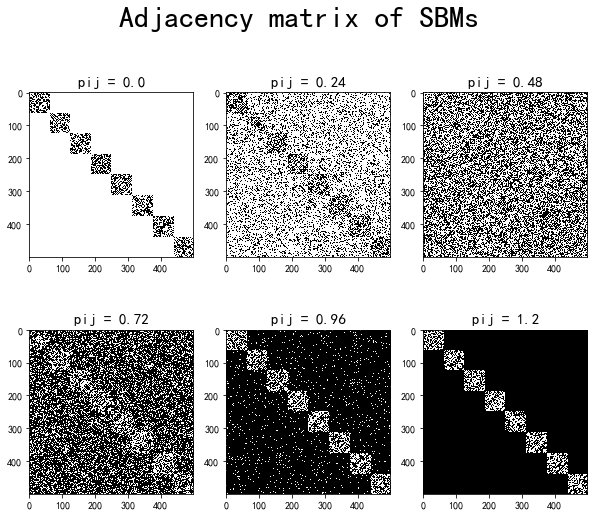

In [172]:
N, k = 500, 8
step = 6
pijs = np.linspace(0, 1.2, step)

fig, axes = plt.subplots(2, step//2, figsize=(10, 8))
fig.suptitle("Adjacency matrix of SBMs", fontsize=30, y=1)

for ax, pij in zip(axes.flatten(), pijs):
    A, _, _ = sbm(N=N, k=k, pij=pij, pii=0.5, sigma=0.2)
    ax.imshow(A, cmap="Greys", interpolation="none")
    ax.set_title(f'pij = {np.round(pij,3)}', fontsize=15)

### plot absolute value of Fourier transform of ground truth cluster labels for each SBM realization

you should one-hot encode your cluster signals into a N x K matrix,
    
where ith column has ones in those entrie which are part of ith cluster, and 0s elsewhere

e.g., if your ground truth labels are `[0, 0, 1, 1, 1]`,

the one hot encoding should be `[ [1, 0], [1, 0], [0, 1], [0, 1], [0, 1] ]

there is a clever way to produce this encoding with a single line of code!

you can then take GFT of one-hot encoded cluster labels 

and can plot each column using `plt.stem`

make sure x-values correspond to graph frequencies, i.e., eigenvalues

Text(0.02, 0.5, 'Absolute value of Graph Fourier Transformed signal')

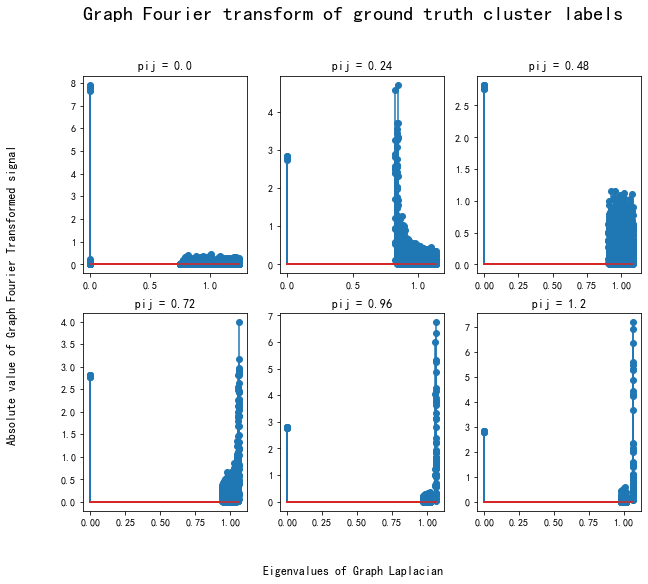

In [174]:
N, k = 500, 8
step = 6
pijs = np.linspace(0, 1.2, step)
fig, axes = plt.subplots(2, step//2, figsize=(10, 8))
fig.suptitle("Adjacency matrix of SBMs", fontsize=30, y=1)

for ax, pij in zip(axes.flatten(), pijs):
    A, gt, _ = sbm(N=N, k=k, pij=pij, pii=0.5, sigma=0.2)
    Laplacian = L(A)    # (N, N)
    e, psi = compute_fourier_basis(Laplacian) # (N, ) (N, N)
    one_hot = np.eye(k)[gt.astype(int)]  # (N, k)
    s_hat = gft(one_hot, psi) # (N, k)

    # x-axis: eigenvalues, y-axis: absolute value of GFTed signal
    for q in range(k):
        ax.stem(e, np.abs(s_hat[:, q]))
    
    ax.set(title=f'pij = {np.round(pij, 3)}')


fig.suptitle("Graph Fourier transform of ground truth cluster labels", 
             fontsize=20, y=1)
fig.supxlabel("Eigenvalues of Graph Laplacian")
fig.supylabel("Absolute value of Graph Fourier Transformed signal")

### plot coordinates of SBM colored by 2nd eigenvector of graph Laplacian at each realization

Text(0.02, 0.5, 'Coordinate 2')

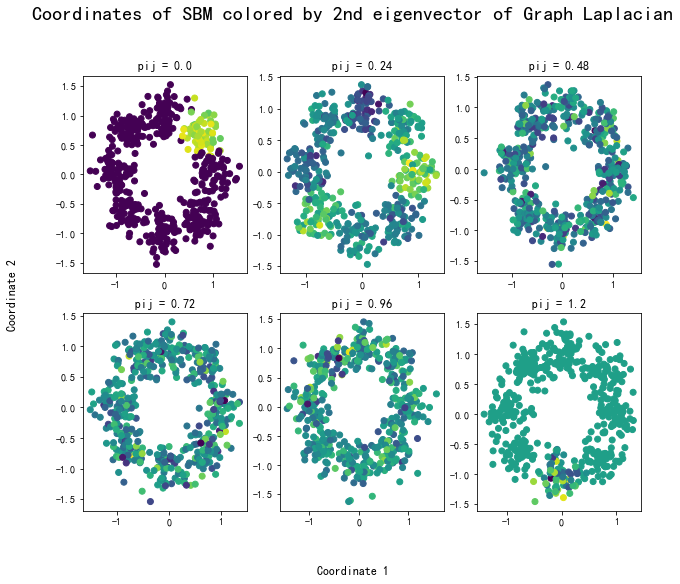

In [178]:
N, k = 500, 8
step = 6
pijs = np.linspace(0, 1.2, step)
fig, axes = plt.subplots(2, step//2, figsize=(10, 8))

for ax, pij in zip(axes.flatten(), pijs):
    A, gt, coord = sbm(N=N, k=k, pij=pij, pii=0.5, sigma=0.2)
    Laplacian = L(A)    # (N, N)
    e, psi = compute_fourier_basis(Laplacian) # (N, ) (N, N)

    ax.scatter(coord[:,0], coord[:,1], c=psi[:,1]) # colored by 2nd eigenvector of graph Laplacian
    ax.set(title=f'pij = {np.round(pij, 3)}')
fig.suptitle("Coordinates of SBM colored by 2nd eigenvector of Graph Laplacian", fontsize=20, y=1)
fig.supxlabel("Coordinate 1")
fig.supylabel("Coordinate 2")

### plot Fourier spectra of Gaussian noise

Text(0.02, 0.5, 'Absolute value of Graph Fourier Transformed Gaussian noise')

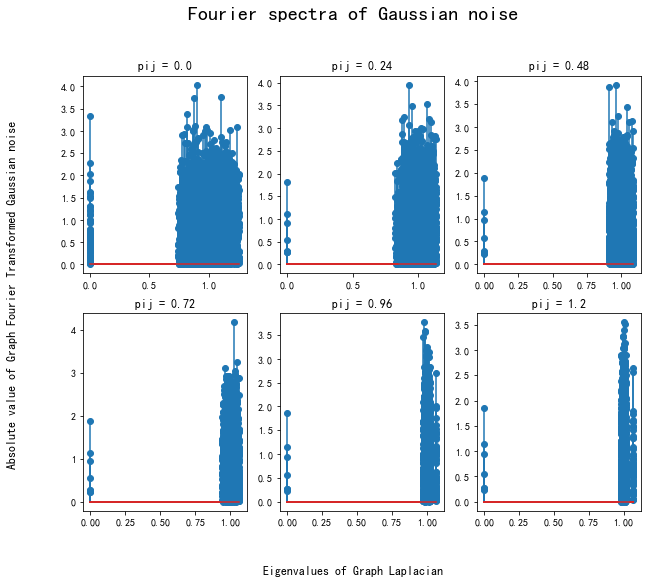

In [179]:
N, k = 500, 8
noise = np.random.randn(N, k)
step = 6
pijs = np.linspace(0, 1.2, step)
fig, axes = plt.subplots(2, step//2, figsize=(10, 8))

for ax, pij in zip(axes.flatten(), pijs):
    A, gt, coord = sbm(N=N, k=k, pij=pij, pii=0.5, sigma=0.2)
    Laplacian = L(A)    # (N, N)
    e, psi = compute_fourier_basis(Laplacian) # (N, ) (N, N)
    s_hat = gft(noise, psi)

    # x-axis: eigenvalues, y-axis: absolute value of GFTed signal
    for q in range(k):
        ax.stem(e, np.abs(s_hat[:, q]))
    
    ax.set(title=f'pij = {np.round(pij, 3)}')

fig.suptitle("Fourier spectra of Gaussian noise", 
             fontsize=20, y=1)
fig.supxlabel("Eigenvalues of Graph Laplacian")
fig.supylabel("Absolute value of Graph Fourier Transformed Gaussian noise")

### filter random Gaussian noise

Text(0.02, 0.5, 'Coordinate 2')

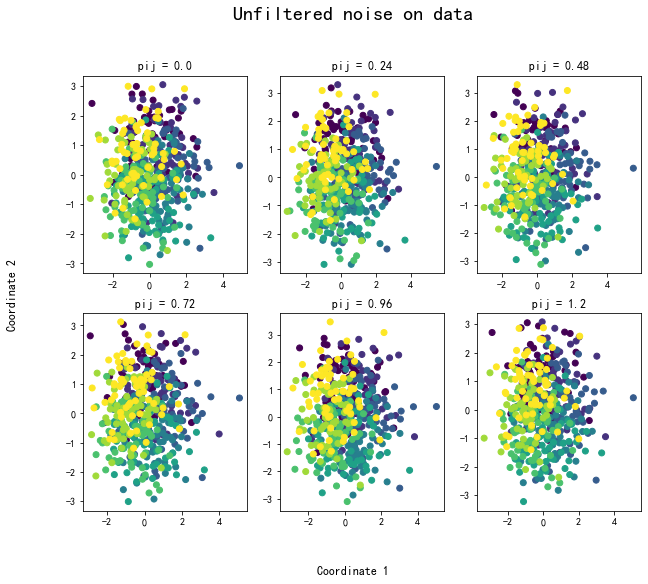

In [187]:
N, k = 500, 8
noise = np.random.randn(N, 2)
step = 6
pijs = np.linspace(0, 1.2, step)
fig, axes = plt.subplots(2, step//2, figsize=(10, 8))

for ax, pij in zip(axes.flatten(), pijs):
    A, gt, coord = sbm(N=N, k=k, pij=pij, pii=0.5, sigma=0.2)
    X = coord + noise 
    ax.scatter(X[:,0], X[:,1], c=gt)
    ax.set_title(f"pij = {np.round(pij, 3)}")

fig.suptitle("Unfiltered noise on data", fontsize=20, y=1)
fig.supxlabel("Coordinate 1")
fig.supylabel("Coordinate 2")

try **low pass filters** to filter random Gaussian noise

plot filtered noise on data coordinates

Text(0.02, 0.5, 'Coordinate 2')

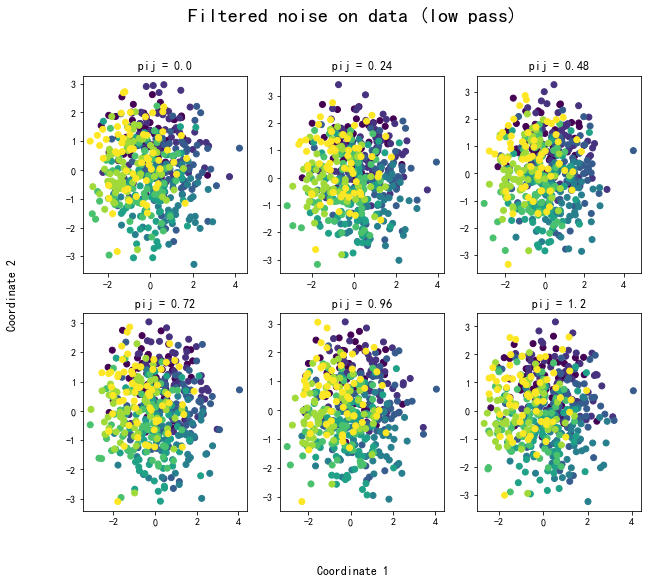

In [189]:
N, k = 500, 8
noise = np.random.randn(N, 2)
step = 6
pijs = np.linspace(0, 1.2, step)
filter = 'low pass'

fig, axes = plt.subplots(2, step//2, figsize=(10, 8))

for ax, pij in zip(axes.flatten(), pijs):
    A, gt, coord = sbm(N=N, k=k, pij=pij, pii=0.5, sigma=0.2)
    Laplacian = L(A)    # (N, N)
    e, psi = compute_fourier_basis(Laplacian) # (N, ) (N, N)
    H = filterbank_matrix(psi, e,  filter)
    X = coord + noise 
    filtered_X = H @ X 
    ax.scatter(filtered_X[:,0], filtered_X[:,1], c=gt)
    ax.set_title(f"pij = {np.round(pij, 3)}")

fig.suptitle(f"Filtered noise on data ({filter})", fontsize=20, y=1)
fig.supxlabel("Coordinate 1")
fig.supylabel("Coordinate 2")

## discussion

- How does spectrum of cluster labels changing at various levels of connectivity?


- what kind of freq content does a stable clustering have?

Answer:

I start pij from 0, and increases pij by 0.2 until 1 and set pii = 0.5

The spectrum of cluster labels is the distribution of graph Laplacian eigenvalues of Graph Fourier Transform of cluster labels, represents the frequency content of signal (i.e., cluster labels)

When pij = 0, there is no connection between clusters, only connections within clusters, so the frequency content of signal is low,

As pij increases, the connection between clusters is increasing, as we can see the plots become more and more dense, means that the frequency content of signal becomes higher

- What do first few Laplacian eigenvectors represent in SBM?

Answer

- In SBM, the first few Laplacian eigenvectors represent low frequency because they are correspond to small eigenvalues.

- The first non-trivial eigenvector correspond to an eigenvalue (Fiedler value) which represents the minimum cut needed to split the graph.


- The third eigenvector and the subsequent eigenvectors after the third can discriminate between clusters while the top 2 eigenvectors don't

- What does filtered noise look like on average?


- What happens when you vary param c?

Answer

- The unfiltered noise on data looks like full of noise while the filtered noise on data looks uniform among clusters. So the filter works


- I first start with threshold c = 0.5 for my filter, then I tried c=0.2, 0.7. The higher the threshold, the more signals remaining after filtering.

# Filtering signals on Swiss Roll

## build graph of Swiss roll

- build a graph using Gaussian kernel params that produce a reasonable diffusion map, i.e. looks like a plane

    use this diffusion map to visualize the signals you generate below

In [11]:
from ps2_functions import load_json_files, gaussian_kernel
from ps1_functions import compute_distances, compute_affinity_matrix, diff_map_info, get_diff_map

Text(0.5, 1.0, 'Diffusion map of Swiss Roll')

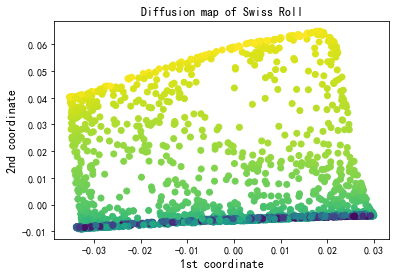

In [12]:
# Read Swiss Roll
leadstring = '/Users/wenxinxu/Desktop/CPSC553/data/swissroll/'
swiss_features = load_json_files(leadstring+'swiss_roll_points.json')
swiss_labels = load_json_files(leadstring+'swiss_roll_labels.json')

D = compute_distances(swiss_features)
W = compute_affinity_matrix(D, "gaussian", sigma=3, k=None)
diff_vec, diff_eig = diff_map_info(W)
diff_map = get_diff_map(diff_vec, diff_eig, 1)


plt.scatter(x=diff_map[:,0], y=diff_map[:,1], 
            c=np.sin(swiss_labels))
plt.xlabel('1st coordinate', size=12)
plt.ylabel('2nd coordinate', size=12)
plt.title("Diffusion map of Swiss Roll" )

## Generate signals of different frequency

1. use coloring label to generate 3 signals: 1 low freq, 1 medium freq, 1 high freq

    plot these signals and show their graph Fourier transform

    report function that you used to generate them

    Hint: use Trigonometric function 三角函数

2. shift phase of your signals

    you could do this by shifting your trig functions along the color vector

fixed bandwidth specified


Text(0.02, 0.5, 'GFT        Shifted        Raw')

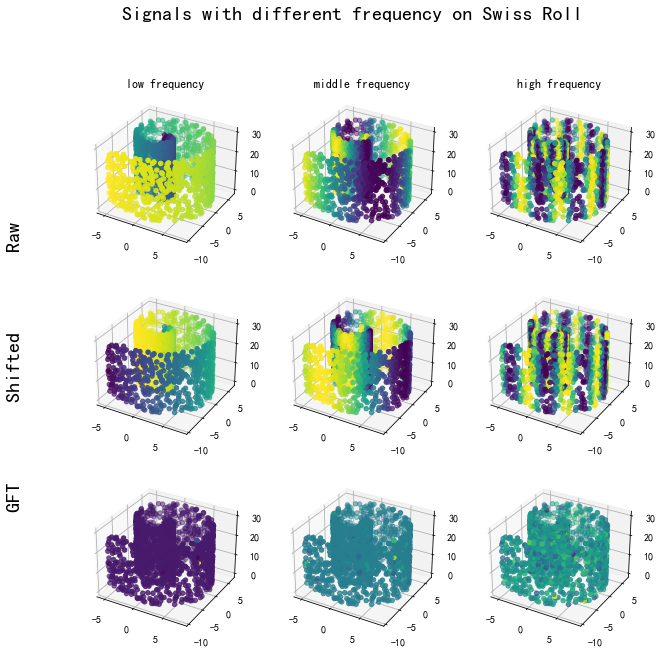

In [33]:
# signals: sin(1), sin(20), sin(100)
shift_scales = [0, 20]
freqs = [1, 20, 100]
freq_labels = ["low", "middle", "high"]
ylabels = ['Raw', 'Shifted', 'GFT']

fig, axes = plt.subplots(len(shift_scales)+1, len(freqs), figsize=(10, 10), 
                         subplot_kw={"projection": "3d"})
x, y, z = swiss_features[:, 0], swiss_features[:, 1], swiss_features[:, 2]

for i, shift_scale in enumerate(shift_scales):
    for j, freq in enumerate(freqs):
        signal = np.sin(freq * swiss_labels + shift_scale)
        axes[i, j].scatter(x, y, z, c=signal)
        if i == 0:
            axes[i, j].set_title(f'{freq_labels[j]} frequency')

# show graph Fourier transform of signals with different frequency
A = gaussian_kernel(swiss_features, kernel_type="gaussian", sigma=3.0, k=None)
Laplacian = L(A, normalized=True)
e, psi = compute_fourier_basis(Laplacian)
for j, freq in enumerate(freqs):
        signal = np.sin(freq * swiss_labels + shift_scale)
        s_hat = gft(signal, psi)
        axes[i+1, j].scatter(x, y, z, c=s_hat)

fig.suptitle("Signals with different frequency on Swiss Roll", fontsize=20, y=1)
fig.supylabel((' '*8).join(ylabels[::-1]), fontsize=20)

## plot filters

plot all of your filters by evaluating them over interval  $[0,\lambda_𝑁)$

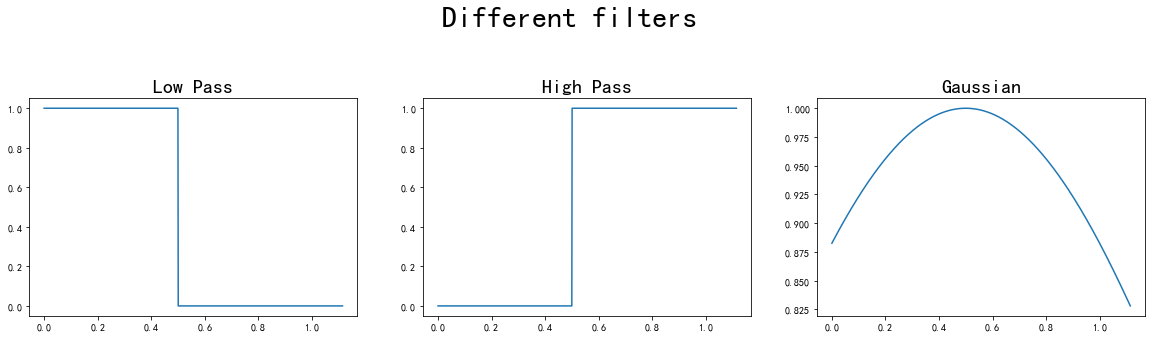

In [37]:
def low_pass(x, c=0.5):
    return [1 if i < c else 0 for i in x]

def high_pass(x, c=0.5):
    return [1 if i > c else 0 for i in x]

def gaussian(x, mu=0.5, sigma=1):
    return np.exp(-(x-mu)**2/(2*sigma**2))


# largest eigenvalue of Laplacian
lmax = e.max()

signal = np.linspace(0, lmax, 1000)

filtered_signal = [low_pass(signal), high_pass(signal), gaussian(signal)]

filter_labels = ["Low Pass", "High Pass", "Gaussian"]

fig = plt.figure(figsize=(20, 4))

fig.suptitle("Different filters", fontsize=30, y=1.2)

for i in range(3):
    axes = fig.add_subplot(1, 3, i+1)
    axes.plot(signal, filtered_signal[i])
    axes.set_title(filter_labels[i], fontsize=20) 

## signal filtering

- try low pass filter, high pass filter, Gabor filter to filter these signals

fixed bandwidth specified


Text(0.5, 1, 'Filtered Signals on Swiss Roll')

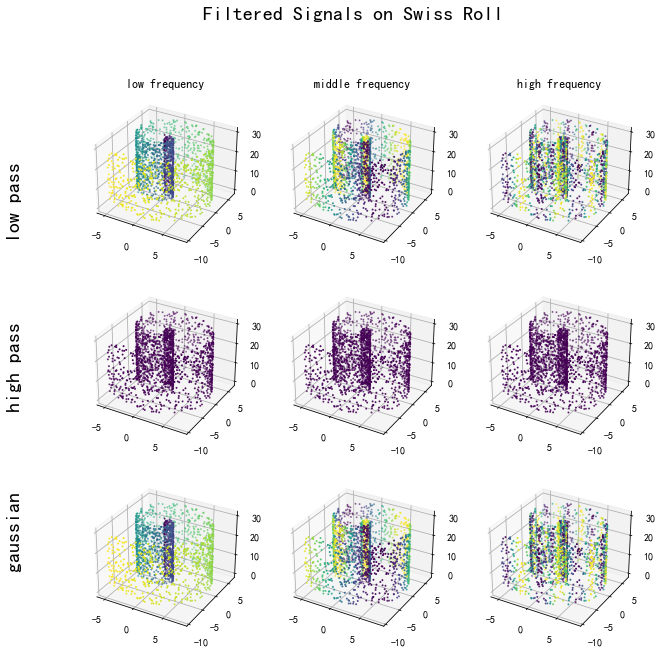

In [34]:
filters = ['low pass', 'high pass', 'gaussian']
freqs = [1, 20, 100]
freq_labels = ["low", "middle", "high"]


A = gaussian_kernel(swiss_features, kernel_type="gaussian", sigma=3.0, k=None)
Laplacian = L(A, normalized=True)
e, psi = compute_fourier_basis(Laplacian)

fig, axes = plt.subplots(len(filters), len(freqs), figsize=(10, 10),
                         subplot_kw={"projection": "3d"})
x, y, z = swiss_features[:, 0], swiss_features[:, 1], swiss_features[:, 2]

for i, filter in enumerate(filters):
    for j, freq in enumerate(freqs):
        signal = np.sin(freq * swiss_labels)
        H = filterbank_matrix(psi, e, filter)
        filtered_signal = H @ signal 
        axes[i, j].scatter(x, y, z, c=filtered_signal, s=1)
        if i == 0:
            axes[i, j].set_title(f'{freq_labels[j]} frequency')

fig.supylabel((' '*8).join(filters[::-1]), fontsize=20)
fig.suptitle("Filtered Signals on Swiss Roll", fontsize=20, y=1)

- apply **Gabor filter** on Swiss roll

    mean = 0.5, sigma = 1.0

build a band pass filter using a Gaussian function like

$$
e^{-\frac{(\lambda - \mu)^2}{2 \sigma^2}}
$$

you can change mean $\mu$ of Gaussian to a desired target $\lambda_k$ in the middle of the band

you can tune the width by changing $\sigma$

now, define **Kronecker Delta** $\delta_i \in \mathbb{R}^{n \times 1}$ as an n x 1 vector filled with 0s but with a 1 in ith entry

$$
[\delta_i]_j=
\left\{\begin{matrix}
1 \text{ if } j=i\\ 
0 \text{ if } j \neq i
\end{matrix}\right.
$$

e.g., if i=3, n=5, then Kronecker Delta is

$$
\delta_3 = [0,0,1,0,0]
$$

- use Kronecker Delta as a signal to translate your Gaussian to a certain point on the graph by taking

$$
H \delta_i
$$

change value of i should move Gaussian to different parts of the graph

- translate it over Swiss roll, record what changing $\lambda_k$ does to the output

In [306]:
def kronecker_delta(i, n):
    """
    @param:
    i: the ith entry of n x 1 vector is 1 with other entries all 0s
    n: the length of the vector
    
    return: an n x 1 Kronecker Delta vector
    """
    v = np.zeros(n)
    v[i-1] = 1
    return v

Please enter mean and sigma with a space: 0.5 1
mean = 0.5, sigma = 1.0


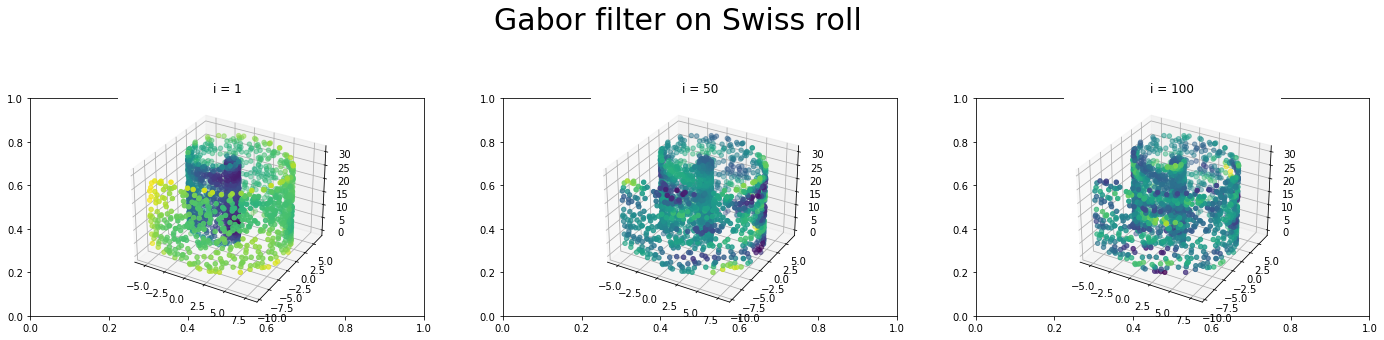

In [324]:
H = filterbank_matrix(psi, e, "gaussian")

# use KD as a signal to translate Gaussian to a certain point on graph
i_list = [1, 50, 100] # change value of i 
s_gaussains = [H @ kronecker_delta(i, H.shape[0]) for i in i_list]

x, y, z = swiss_features[:, 0], swiss_features[:, 1], swiss_features[:, 2]
fig, axes = plt.subplots(1, 3, figsize=(24, 4))
fig.suptitle("Gabor filter on Swiss roll", fontsize=30, y=1.2)

for i in range(3):
    axes = fig.add_subplot(1, 3, i+1, projection='3d')
    axes.scatter(x, y, z, 
                 c=s_gaussains[i])
    axes.set_title(f'i = {i_list[i]}')


## discussion

- What does smoothness mean in terms of graph signals and their freq spectrum?

Answer:

There are several ways to measure smoothness: Laplacian quadratic form and graph spectral representation.

In the graph signal domain (vertex domain), smoothness is related to connectivity of a graph. A smooth signal can't feature values that decay too quickly from the peak value.

In the frequency spectral domain, the Graph Fourier Transform of a smooth signal decays rapidly. The smooth signal can be compressed because they can be approximated by just a few graph Fourier coefficients. A smooth signal has energy in low frequencies in the graph spectral plot, while a less smooth signal has energy in high frequencies.

- band-limiting is a nice trait if one wants to design an algo.

    means there is no freq content above a certain freq, i.e. band limit
    
    for what values of $p_{ij}$ are SBM cluster labels band-limited?

Answer:

The band limit is the threshold value above which all the Graph Fourier Trasnform values are near 0. With pii = 0.5, when pij = 0, the band limit ≈ 0.7, when pij ∈ {0.2, 0.4, 0.6, 0.8}, band limit ≈ 1.2.

- under what scenarios would you want a band pass or high pass filter?


- how do these filters work and what do they do to spectrum of signals?

Answer: 

Band pass filter: i.e. Gaussian filter. If we want signals pass within a specific range of frequencies (frequency band), decay outside the range, also we want the transition between unfiltered signal and filtered signal is smooth, we can use a band pass filter.

High pass filter: if we want high-frequency signals pass for a threshold while low-frequency signals decay, we can use a high-pass filter.

- are there any similarities between band pass experiment and classical translation and modulation?

Answer:

Yes. Band pass filter decays signals that doesn't follow the Gaussian distribution. 

Classical translation magnifies signals that follow the Gaussian distribution and keeps signals that doesn't follow the Gaussian distribution. 

Modulation keeps and magnifies all of the relevant signals.

# k-means clustering

implement k-means clustering using k-means++ initialization

3 steps

1. fill in k-means function `kmeans()`


2. fill in k-means++ initialization function `kmeansplusplus()`


3. test on a Gaussian mixture model with K components

## implement k-means

- k-means works by iteratively selecting cluster labels that are closest to a point


- i.e., at each i, select centroid of the nearest cluster, use squared Euclidean distance


- after you have reassigned all points based on their nearest centroid,

    you then update all the centroids based on their new members
    
    
- repeat the process until the cluster assignments stop changing, within some small tolerance


- if algo doesn't converge, terminate it when reach `itermax` iterations


- to gain accuracy, take `nrep` repetitions and choose cluster assignments that have smallest within cluster distance to centroid

sklearn k-means


https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [ ]:
kmeans = KMeans(n_clusters=k, init='k-means++',
                n_init=10, max_iter=20).fix(X)
labels = kmeans.labels_

### implement k-means++ initialization

- the algo has been shown to be a relatively good way to initialize k-means


- first, choose a single initial point at random to create 1st centroid $c_1$


- for each remaining point, compute squared distance to nearest centroid and make it a probability distribution 

$$
p(x_j)=\frac{\min_{c_i}D^2(c_i, x_j)}{\sum _k \min_{c_i}D^2(c_i, x_k)}
$$

where probability of choosing point $x_j$ is the distance from $x_j$ to the nearest centroid, divided by total distance of all points to this centroid $c_i$

for 1st iteration, this will be distance from each point to 1st centroid $c_1$, divided by the total distance from each point to $c_1$


- sample an $x_j$ with probability proportional to $p(x_j)$

    you can use `np.random.choice` function,
    
    use your vector of probabilities as weights
    
    the weighted selection will be the next centroid $c_2$


- repeat until you have k initial centroids

In [103]:
def kmeans_plusplus(X: np.ndarray, k: int) -> np.ndarray:
    """kmeans_plusplus: initialization algorithm for kmeans
    Args:
        X: input data, rows = points, cols = dimensions (N, d)
        k (int): Number of clusters to partition

    Returns:
        centroids: centroids for initializing k-means (k, d)
    """
    N, d = X.shape
    D = squareform(pdist(X)) # pairwise distance matrix of X with shape (N, N)

    centroids = np.zeros((k, d))
    # Pick first centroid randomly
    centroid_id = np.random.randint(0, N, size=1)
    centroids[0] = X[centroid_id]
    # Pick the remaining k-1 centroids
    for c in range(1, k):
        squared_dist = D[centroid_id]** 2
        p = (squared_dist / squared_dist.sum()).reshape(N, )
        # randomly sample a new centroid weighted by probability distribution
        centroid_id = np.random.choice(N, 1, p=p)

        centroids[c] = X[centroid_id]

    return centroids

In [113]:
def kmeans(X: np.ndarray, k: int, n_init: int=5, max_iter: int=300) -> np.ndarray:
    """kmeans: cluster data into k partitions

    Args:
        X: input data, rows = points, cols = dimensions (N, d)
        k: Number of clusters to partition
        n_init: Number of times the k-means algorithm is run with different centroid seeds. 
                The final results is the best output of n_init consecutive runs in terms of inertia.
        max_iter: Number of iterations to perform before terminating
    Returns:
        labels: Cluster labels assigned by kmeans (N, )
    """
    N = X.shape[0]
    labels = np.zeros((n_init, N), dtype=int)
    mindist_sum = np.zeros(n_init)
    
    for i in range(n_init): 
        init = kmeans_plusplus(X, k) # initialize centroids by k-means++ (k, d)
        for _ in range(max_iter):   
            for j in range(N):
                mindist = np.inf
                for q, centroid in enumerate(init):
                    dist = np.linalg.norm(X[j] - centroid)
                    if dist < mindist:
                        centroid_id, mindist = q, dist  
                labels[i][j] = centroid_id
                mindist_sum[i] += mindist
    
    return labels[np.argmin(mindist_sum/N)]

## k-means on Gaussian Mixture

- test on a Gaussian mixture model (GMM) with K components
    
- to generate this GMM, we just use `sbm` function to generate coordinates, discarding weighted adjacency matrix returned by SBM
    
- run k-means on your GMM with various values of variance sigma

In [53]:
# create a Gaussian mixture model (GMM) with k components
N = 500
k = 8 
pii = 0.8 
pij = 0.5
sigmas = np.linspace(0.01, 0.1, 4) 

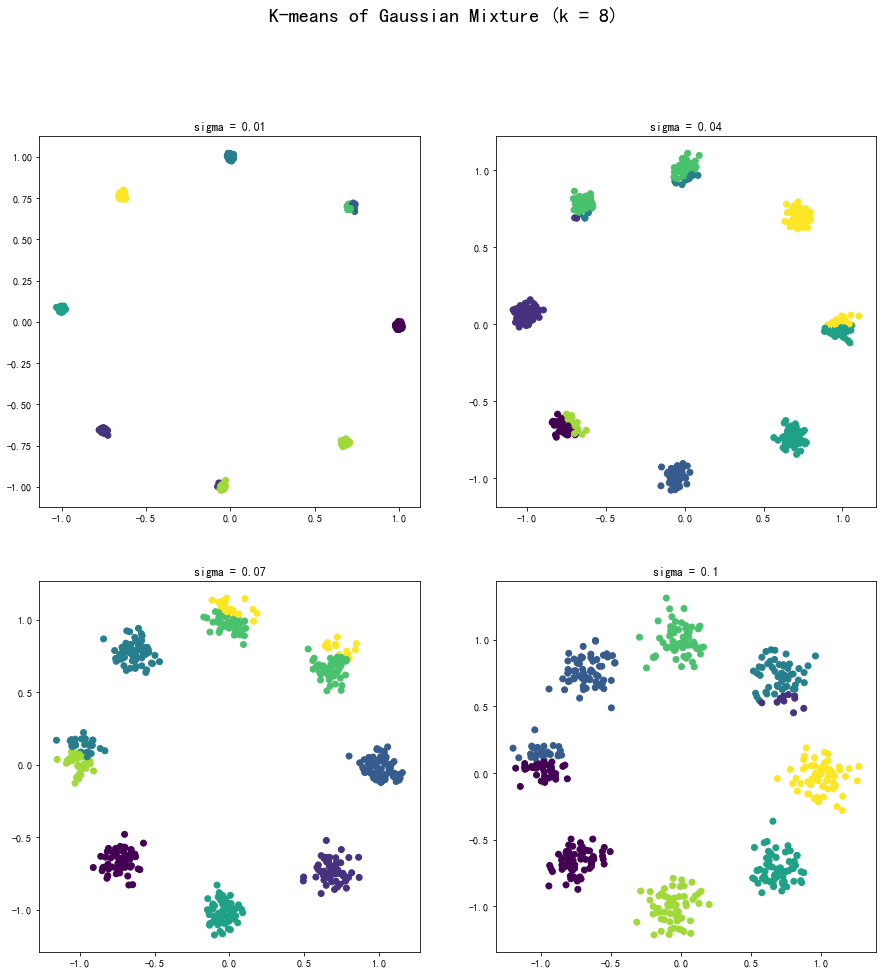

In [116]:
fig, axes =plt.subplots(2, 2, figsize=(15, 15))

fig.suptitle(f"K-means of Gaussian Mixture (k = {k})", fontsize=20, y=1)

for i, (sigma, ax) in enumerate(zip(sigmas, axes.flatten())):
    _, _, coord = sbm(N, k, pij, pii, sigma)
    labels = kmeans(coord, k=k)
    ax.scatter(coord[:,0],coord[:,1], c = labels)
    ax.set_title(f'sigma = {np.round(sigma, 3)}') 

## k-means on Concentric Spherical

generate a concentric spherical 同心球 dataset by sampling 1000 points from a 3d standard normal distribution

normalize all points using Euclidean distance

this should from a hollow sphere 中空的球体

multiply 1st 500 points by 10,

this should create concentric spheres

each sphere will be a separate cluster
    
run k-means on this

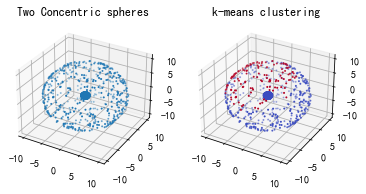

In [115]:
mean = np.array([0, 0, 0])
cov = np.eye(3)
size = 1000
 
# randomly sample 1000 points from a 3d normal distribution
sphere = np.random.multivariate_normal(mean=mean, cov=cov, size=size)

# normalize all points using Euclidean distance of row
sphere = sphere/np.linalg.norm(sphere, axis=-1, keepdims=True)

# multiply first 500 points by 10 to create concentric spheres
# each sphere is a separate cluster
sphere[0:500, :] *= 10 

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(sphere[:, 0], sphere[:, 1], sphere[:, 2], s=1)
ax.set(xlabel="x", ylabel='y', zlabel='z', title="Two Concentric spheres")

# run k-means on 2 concentric spheres
k_means = kmeans(sphere, k=2)
ax = fig.add_subplot(122, projection='3d')
ax.scatter(sphere[:, 0], sphere[:, 1], sphere[:, 2], s=1, c=k_means, cmap=cm.coolwarm)
ax.set_title("k-means clustering")
plt.show()

## Discussion

- compare labels you obtain on SBM to ground truth clusters

    at what values of sigma does k-means clustering start to fail?
    

Answer: 

I test 6 values of sigma (0.01, 0.032, 0.055, 0.078, 0.1), when sigma = 0.032, the k-means clustering can't correctly differentiate all the ground truth clusters.

- does k-means converge to a reasonable clustering on concentric spheres?


- why?

Answer:

No. We can see in the k-means plot of 2 concentric spheres when using k=2, both the outer sphere and the dense inner small sphere are colored by red. This is because the k-means method can only distinguish between clusters with different means, while in this case the means of the 2 concentric spheres are the same: [0, 0, 0].

# spectral clustering

Algorithm

1. build or obtain a graph


2. construct normalized graph Laplacian


3. take 1st k eigenvectors


4. normalize rows of these eigenvectors using $l_2$ norm


5. run k-means on normalized output

- spectral clustering works by treating the eigenvectors of $\mathcal L$ as coordinates for your points


- we will use the method in equation 4. this is a useful tutorial equation 5


- for a signal $s \in \mathbb{R}^N$ defined on the vertices of a graph

$$
\hat s (\lambda_l) = \left \langle s, \psi _l \right \rangle\\[1em]
\hat s = \Psi ^T s
$$


- as in the classical Fourier transform, we have a unitary transformation, 

    so we can perform Inverse Graph Fourier Transform as (5)
    
    $$
    s = \Psi \hat s
    $$

## implement Spectral Clustering

In [120]:
def SC(L: np.ndarray, k: int, psi: np.ndarray=None, n_init: int=5, max_iter: int=300, sklearn: bool=False) -> np.ndarray:
    """spectral clustering
    Args:
        L: Normalized graph Laplacian. (N, N)
        k: number of clusters to compute
        n_init: Number of initialization to average for final clustering
        max_iter: Number of iterations to perform before terminating
        sklearn: Flag to use sklearn kmeans to test your algorithm
    Returns:
        labels: Learned cluster labels (N,)
    """
    # compute the first k elements of the Fourier basis
    if psi is None:
        psi_k = eigh(L)[1][:, :k] 
    else:
        psi_k = psi[:, :k]

    # row normalize eigenvector
    psi_norm = psi_k / np.linalg.norm(psi_k, axis=-1, ord=2, keepdims=True)

    if sklearn: 
        labels = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter).fit_predict(psi_norm)
    else:
        labels = kmeans(X=psi_norm, k=k, n_init=n_init, max_iter=max_iter)

    return labels

## use function

- repeat k-means experiment but using spectral clustering

1. SBM: run spectral clustering on your SBM with various values of sigma and $p_{ij}$


2. concentric spheres: generate a concentric spherical 同心球 dataset by sampling 1000 points from a 3d unit normal distribution same as k-means clustering
   
    use a **Gaussian kernel** to generate graph for these spheres,
    
    run spectral clustering on this

3. generate multiple instantiations of Gaussian noise on the concentric spheres,

    vary the variance of the noise,
    
    and filter them using an ideal low-pass filter


4. finally, use your SBM to generate coordinates as in regular k-means

    but generate an adjacency matrix for these points using Gaussian kernel,
    
    this concoction (mixture) is called **Gaussian Mixture model**
    

5. compare these results to the ones you find in our initial k-means experiment

## Spectral clustering on SBM

hyperparameters: sigma and $p_{ij}$

In [117]:
# create SBM dataset
N = 500
k = 8
pii = 0.8
pij_step, sigma_step = 4, 4
pijs = np.linspace(0, 1, pij_step)
sigmas = np.linspace(0.01, 0.1, sigma_step)

Text(0.5, 0.95, 'Spectral clustering of SBM')

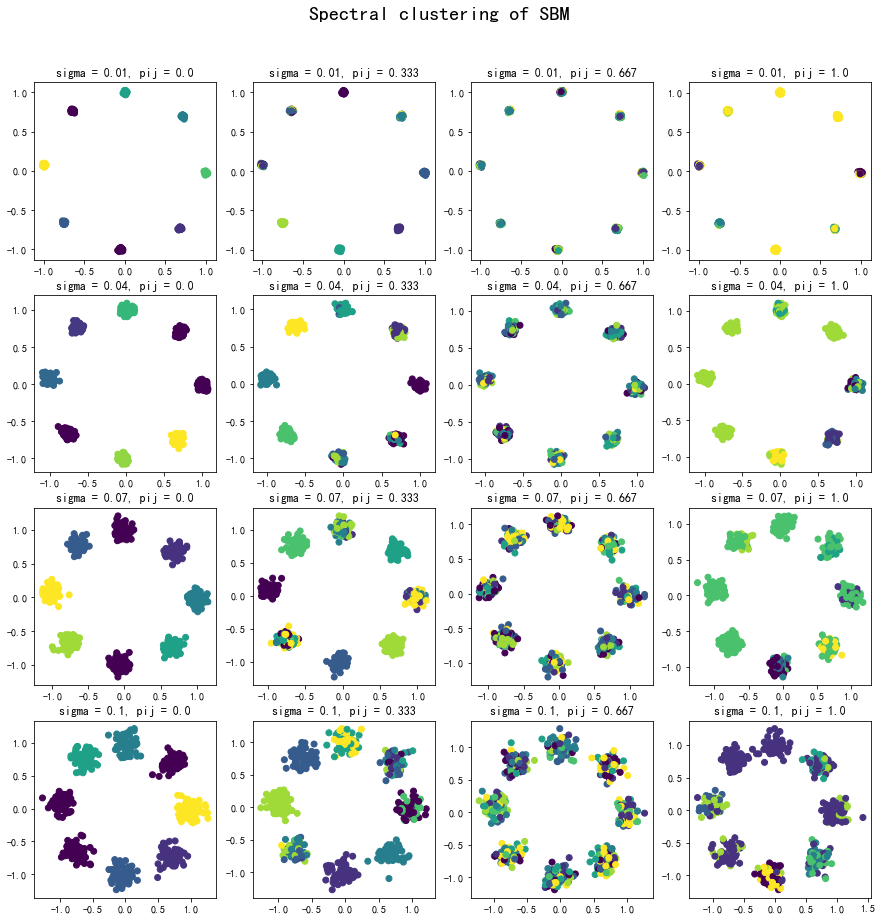

In [122]:
fig, axes = plt.subplots(sigma_step, pij_step, figsize=(15, 15))

for i, sigma in enumerate(sigmas):
    for j, pij in enumerate(pijs):
        A, gt, coord = sbm(N, k, pij, pii, sigma)
        labels = SC(L(A), k, sklearn=False) 
        axes[i][j].scatter(coord[:, 0], coord[:, 1], c=labels) 
        axes[i][j].set_title(f'sigma = {np.round(sigma,3)}, pij = {np.round(pij, 3)}')
fig.suptitle("Spectral clustering of SBM", fontsize=20, y=0.95)

## Spectral clustering on Gaussian mixture

use your SBM to generate an adjacency matrix for these points using Gaussian kernel,

try different bandwidth

this concoction (mixture) is called Gaussian Mixture model

In [195]:
N = 500
k = 8
pii = 0.8
pij = 0
sigma = 0.1
A, gt, coord = sbm(N, k, pij, pii, sigma)

fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


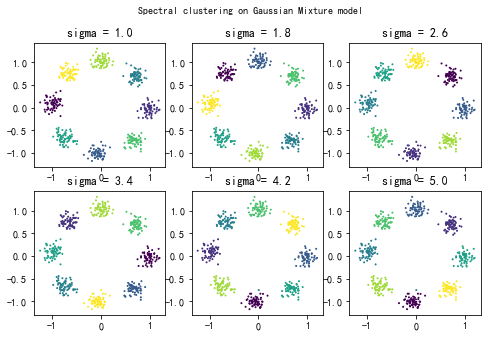

In [196]:
step = 6
sigmas = np.linspace(1, 5, step)

fig, axes = plt.subplots(2, step//2, figsize=(8, 5))
plt.suptitle("Spectral clustering on Gaussian Mixture model", fontsize=10)

for sigma, ax in zip(sigmas, axes.flatten()):
    labels = SC(L(gaussian_kernel(coord, sigma=float(sigma))), k, sklearn=True)   
    ax.scatter(coord[:, 0], coord[:, 1], c=labels, s=1)
    ax.set_title(f'sigma = {np.round(sigma, 3)}')

## Spectral clustering on Concentric spherical

### make graph by Gaussian kernel

use a **Gaussian kernel** to generate graph for these spheres,

run spectral clustering on this

In [39]:
mean = np.array([0, 0, 0])
cov = np.eye(3)
size = 1000
 
# randomly sample 1000 points from a 3d unit normal distribution
sphere = np.random.multivariate_normal(mean=mean, cov=cov, size=size)

# normalize all points using Euclidean distance of row
sphere = sphere/np.linalg.norm(sphere, axis=-1, keepdims=True)

# multiply first 500 points by 10 to create concentric spheres
# each sphere should be a separate cluster
sphere[0:500, :] *= 10 

fixed bandwidth specified


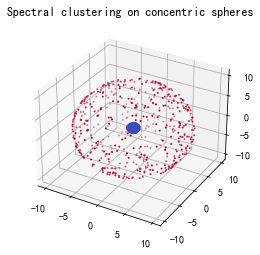

In [151]:
# use Gaussian kernel to convert data into a graph 
G = gaussian_kernel(sphere)

# run spectral clustering on graph data
labels = SC(L(G), k=2, sklearn=False) 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere[:,0],sphere[:,1],sphere[:,2], s=1, c = labels, cmap = cm.coolwarm)
ax.set(xlabel="x", ylabel='y', zlabel='z', title="Spectral clustering on concentric spheres")
plt.show() 

### plot noise filtered by low pass filter

plot noise filtered by low pass filter on concentric spheres:

generate Gaussian noise with different variance on the concentric spheres,

and filter them using an ideal low-pass filter

fixed bandwidth specified


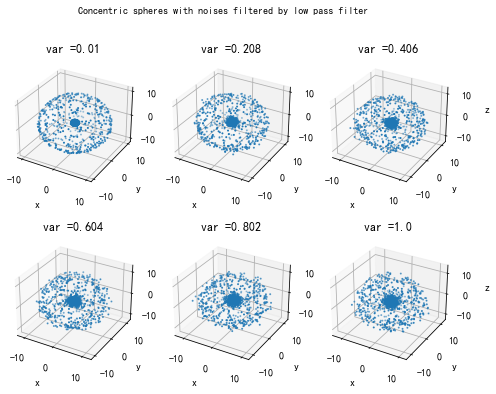

In [169]:
mean = np.array([0, 0, 0])
cov = np.eye(3)
size = 1000

X = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
X = X/np.linalg.norm(X, axis=-1, keepdims=True)
X[0:500, :] *= 10 

G = gaussian_kernel(X)
e, psi = compute_fourier_basis(L(G))
H = filterbank_matrix(psi, e, "low pass")
step = 6
vars = np.linspace(0.01, 1, step)

fig, axes = plt.subplots(2, step//2, figsize=(8, 6), 
                         subplot_kw={"projection": "3d"})
plt.suptitle("Concentric spheres with noises filtered by low pass filter", 
             size=10)

for var, ax in zip(vars, axes.flatten()):
    noise = np.random.multivariate_normal(mean=mean, cov=var*cov, size=size) 
    noisyX = X+noise

    s_hat = H @ noisyX
    ax.scatter(s_hat[:,0],s_hat[:,1],s_hat[:,2], s=1)
    ax.set(xlabel="x", ylabel='y', zlabel='z', title=f"var ={np.round(var,3)}")


## discussion

- compare the labels you obtain on SBM to ground truth clusters


- at what values of sigma and $p_{ij}$ does spectral clustering start to fail?

Answer

I try 30 different combinations of sigma from (0.01, 0.032, 0.055, 0.078, 0.1) and pij from (0, 0.2, 0.4, 0.6, 0.8, 1) to create SBM and run spectral clustering on them. In my case, no matter what values of sigma is, at pij = 0.02, the spectral clustering starts to fail, but as sigma increases, the degree of failure also increases.

- How does spectral clustering compare to k-means on SBM?

    Answer: Spectral clustering is better than k-means on SBM. 

- How does using SBM adjacency matrix compare to creating one from a Gaussian kernel?

    I don't see difference between using Gaussian kernel and using SBM adjacency matrix.  

- How does spectral clustering compare to k-means on concentric spheres?

Answer: Spectral clustering is better than k-means on SBM. It successfully differentiate the outer sphere (blue) from the inter sphere (red) while k-means can't do that.

- How does kernel width affect output of clustering?

Answer: I don't see significant difference between spectral clustering with different Gaussian kernel width, the results of clustering are all good, all the 8 clusters are clearly differentiated.

- compare cluster labels of spectral clustering to filtered noise on concentric spheres


- what's freq content of label vector?


- discuss connection between Spectral clustering and Graph Fourier Transform

Answer: with filtered noise, the frequency of ground truth labels becomes low. In spectral clustering, we choose the smallest eigenvalues corresponding to the low frequency eigenvectors. So when we do clustering, we are using the low frequency eigenbasis. Using Graph Fourier Transform to filter the noise has same effect as spectral clustering. We project noise on eigenvector and get a few coefficients, then high frequency components are filtered. The filtered data (coefficients multiply eigenvalue) only includes low frequency signals. 

- in the case that you don't have some pathological geometry 不正常的几何形状

    i.e. concentric spheres
    
    when would you use spectral clustering?

Answer: we can use spectral clustering on adjacency matrix or high dimensional data, because we only needs adjacency matrix to do spectral clustering and it performs dimensionality reduction.

# Louvain clustering on PHATE and tSNE embedding

- before we only test several clustering methods on low dim data that is easy to visualize.


- now we experiment with t-SNE and PHATE, methods that can embed any dataset into a nice visualization


- we use datasets we know real visualizations


- we also experiment last clustering method - Louvian (paper 6)

    and use t-SNE and PHATE to visualize the effects of change Louvian's hyperparams


`python-louvain` package for Louvain clustering


hyperparameter: `resolution`
    
size of the communities, default to 1.
    
represents the time described in "Laplacian Dynamics and Multiscale Modular Structure in Networks"

In [ ]:
!pip install python-louvain
import networkx as nx 
import community as community_louvain 

# convert numpy adjacency matrix into a NetworkX graph
G = nx.from_numpy_array(A)

labels = list((community_louvain.best_partition(G, resolution=0.1)).values())

4 steps

1. run Louvain on each past examples

    - SBM graphs with different $p_{ij}$
    
    - GMM with different sigmas
    
    - concentric spheres


2. visualize Louvain clusterings


3. use t-SNE to visualize best clustering found by Louvain


4. use PHATE to visualize best clustering found by Louvain

## Louvain clustering on SBM

In [190]:
# create SBM dataset
N = 500
k = 8
pii = 0.8
pij = 0.5
sigma = 0.1 
A, gt, coord = sbm(N, k, pij, pii, sigma)

Text(0.5, 0.95, 'Louvain clustering on SBM')

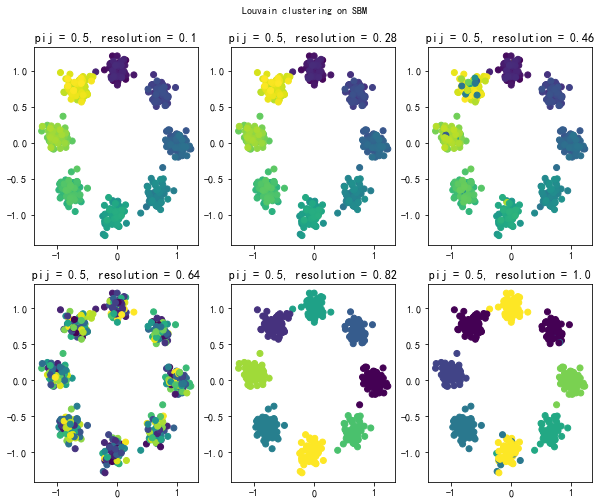

In [194]:
# change resolution of Louvain clusterings
resolution_step = 6
resolutions = np.linspace(0.1, 1, resolution_step) 

fig, axes = plt.subplots(2, resolution_step//2, figsize=(10, 8))

for ax, res in zip(axes.flatten(), resolutions):
    G = nx.from_numpy_array(A)
    labels = list((community_louvain.best_partition(G, resolution=res)).values())
    ax.scatter(coord[:, 0], coord[:, 1], c=labels) 
    ax.set_title(f'pij = {np.round(pij, 3)}, resolution = {np.round(res, 3)}')

plt.suptitle(f"Louvain clustering on SBM", size=10, y=0.95) 

## Louvain clustering on GMM

In [197]:
# create Gaussian Mixture Model
N = 500
k = 8
pii = 0.8
pij = 0.5
sigma = 0.1 
A, gt, coord = sbm(N, k, pij, pii, sigma)

fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


Text(0.5, 0.95, 'Louvain clustering on GMM')

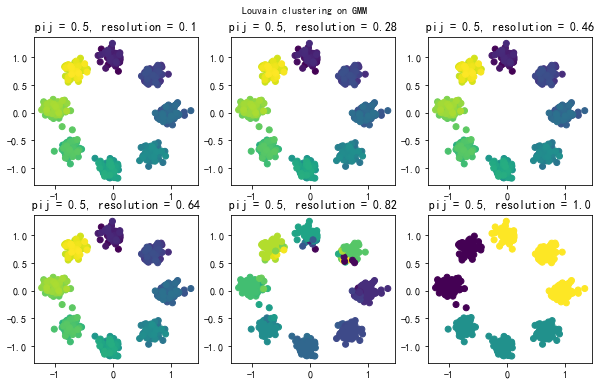

In [198]:
# change resolution of Louvain clusterings
resolution_step = 6
resolutions = np.linspace(0.1, 1, resolution_step) 

fig, axes = plt.subplots(2, resolution_step//2, figsize=(10, 6))

for ax, res in zip(axes.flatten(), resolutions):
    G = nx.from_numpy_array(gaussian_kernel(coord))
    labels = list((community_louvain.best_partition(G, resolution=res)).values())
    ax.scatter(coord[:, 0], coord[:, 1], c=labels) 
    ax.set_title(f'pij = {np.round(pij, 3)}, resolution = {np.round(res, 3)}')

plt.suptitle(f"Louvain clustering on GMM", size=10, y=0.95) 

## Louvain clustering on concentric spheres

fixed bandwidth specified


Text(0.5, 1, 'Louvain clustering on two concentric spheres')

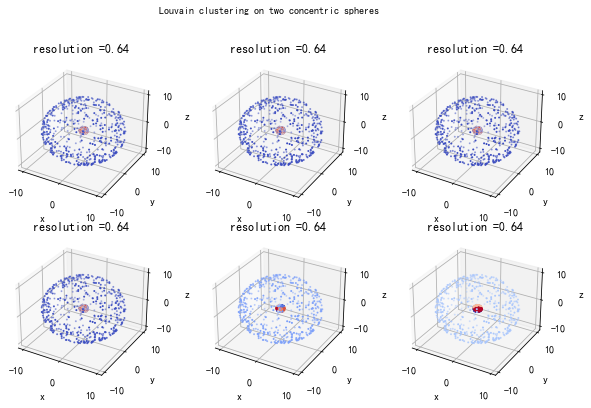

In [201]:
# create 2 concentric spheres
mean = np.array([0, 0, 0])
cov = np.eye(3)
size = 1000
X = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
X = X/np.linalg.norm(X, axis=-1, keepdims=True)
X[0:500, :] *= 10 

G = nx.from_numpy_array(gaussian_kernel(X)) 

# change resolution of Louvain clusterings
resolution_step = 6
resolutions = np.linspace(0.1, 1, resolution_step)

fig, axes = plt.subplots(2, resolution_step//2, figsize=(10, 6),
                         subplot_kw={'projection': '3d'})

for ax, res in zip(axes.flatten(), resolutions):
    labels = list(community_louvain.best_partition(G, resolution=res).values())
    ax.scatter(X[:,0],X[:,1],X[:,2], s=1, c=labels, cmap = cm.coolwarm)
    ax.set(xlabel='x', ylabel='y', zlabel='z', title = f"resolution ={np.round(resolutions[i],3)}")


plt.suptitle("Louvain clustering on two concentric spheres", size=10, y=1)

## t-SNE and PHATE visualization

use `scikit-learn` for t-SNE

change t-SNE's hyperparameter `perplexity` to find optimal representation of Louvain's clusters

### SBM

In [217]:
# create SBM dataset
N = 500
k = 8
pii = 0.8
pij = 0.5 
sigma = 0.1
resolution = 0.2 
A, gt, coord = sbm(N, k, pij, pii, sigma)
G = nx.from_numpy_array(A) 
labels = list((community_louvain.best_partition(G, resolution=resolution)).values())

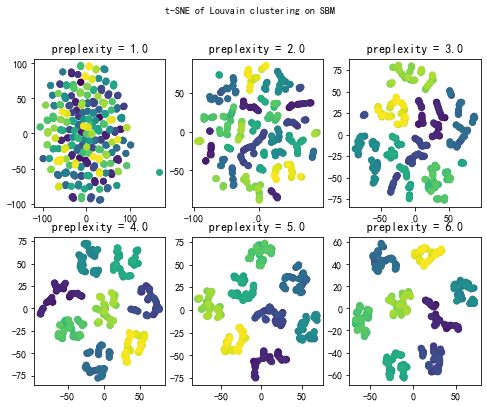

In [208]:
step = 6 
perplexitys = np.linspace(1, 6, step)

fig, axes =plt.subplots(2, step//2, figsize=(8, 6))
 
plt.suptitle("t-SNE of Louvain clustering on SBM", size=10, y=1) 
 
for ax, perp in zip(axes.flatten(), perplexitys):
    embed = TSNE(n_components = 2, perplexity = perp).fit_transform(coord)
    ax.scatter(embed[:,0],embed[:,1], c = labels)
    ax.set_title(f'preplexity = {np.round(perp, 3)}') 


Calculating PHATE...
  Running PHATE on 500 observations and 2 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.10 seconds.
Calculated PHATE in 0.29 seconds.
Calculating PHATE...
  Running PHATE on 500 observations and 2 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.20 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.06 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.11 seconds.
Calculated PHATE in 0.39 seconds.
Calculating PHATE...
  Running PHATE on 500 observations a

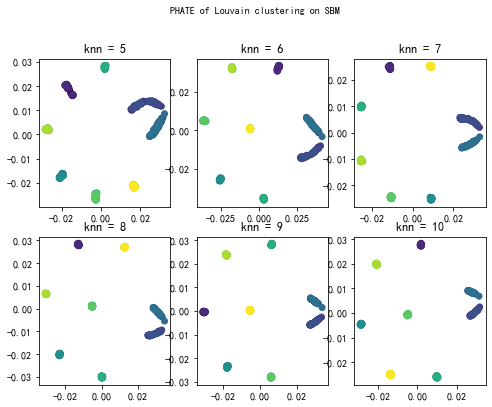

In [223]:
step = 6 
knns = np.linspace(5, 10, step, dtype=int)

fig, axes =plt.subplots(2, step//2, figsize=(8, 6))
plt.suptitle("PHATE of Louvain clustering on SBM", size=10, y=1) 
for ax, knn in zip(axes.flatten(), knns):
    embed = PHATE(n_components = 2, knn=knn).fit_transform(coord)
    ax.scatter(embed[:,0],embed[:,1], c = labels)
    ax.set_title(f'knn = {knn}') 


### GMM

fixed bandwidth specified


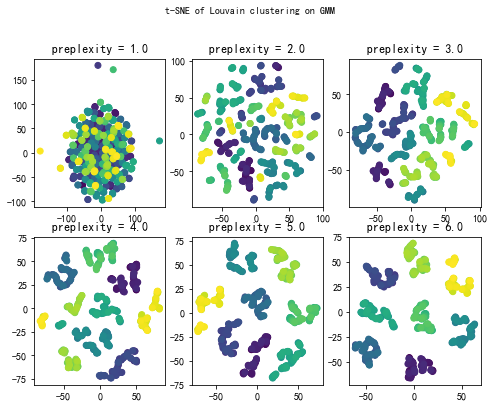

In [210]:
# create Gaussian Mixture Model
N = 500
k = 8
pii = 0.8
pij = 0.4
sigma = 0.1
resolution = 0.2 
A, gt, coord = sbm(N, k, pij, pii, sigma)
G = nx.from_numpy_array(gaussian_kernel(coord))
labels = list((community_louvain.best_partition(G, resolution=resolution)).values())
step = 6 
perplexitys = np.linspace(1, 6, step)

fig, axes =plt.subplots(2, step//2, figsize=(8, 6))
 
plt.suptitle("t-SNE of Louvain clustering on GMM", size=10, y=1) 
 
for ax, perp in zip(axes.flatten(), perplexitys):
    embed = TSNE(n_components = 2, perplexity = perp).fit_transform(coord)
    ax.scatter(embed[:,0],embed[:,1], c = labels)
    ax.set_title(f'preplexity = {np.round(perp, 3)}') 

fixed bandwidth specified
Calculating PHATE...
  Running PHATE on 500 observations and 2 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.10 seconds.
Calculated PHATE in 0.27 seconds.
Calculating PHATE...
  Running PHATE on 500 observations and 2 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.11 seconds.
Calcula

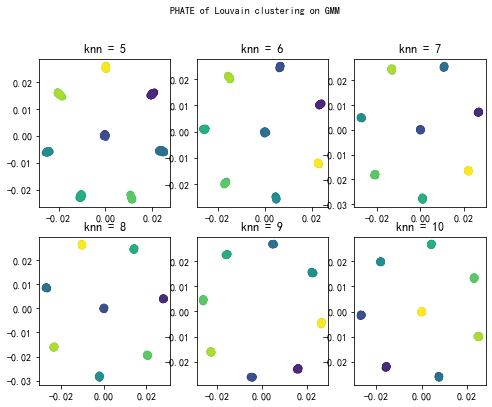

In [225]:
# create Gaussian Mixture Model
N = 500
k = 8
pii = 0.8
pij = 0.4
sigma = 0.1
resolution = 0.2 
A, gt, coord = sbm(N, k, pij, pii, sigma)
G = nx.from_numpy_array(gaussian_kernel(coord))
labels = list((community_louvain.best_partition(G, resolution=resolution)).values())

step = 6 
knns = np.linspace(5, 10, step, dtype=int)

fig, axes =plt.subplots(2, step//2, figsize=(8, 6))
 
plt.suptitle("PHATE of Louvain clustering on GMM", size=10, y=1) 
 
for ax, knn in zip(axes.flatten(), knns):
    embed = PHATE(n_components = 2, knn=knn).fit_transform(coord)
    ax.scatter(embed[:,0],embed[:,1], c = labels)
    ax.set_title(f'knn = {knn}') 

### Concentric sphere

In [226]:
# create 2 concentric spheres
mean = np.array([0, 0, 0])
cov = np.eye(3)
size = 1000
X = np.random.multivariate_normal(mean=mean, cov=cov, size=size)
X = X/np.linalg.norm(X, axis=-1, keepdims=True)
X[0:500, :] *= 10 
G = nx.from_numpy_array(gaussian_kernel(X))
labels = list((community_louvain.best_partition(G, resolution=resolution)).values())

fixed bandwidth specified


Text(0.5, 1, '2D t-SNE of Louvain clustering on two concentric spheres')

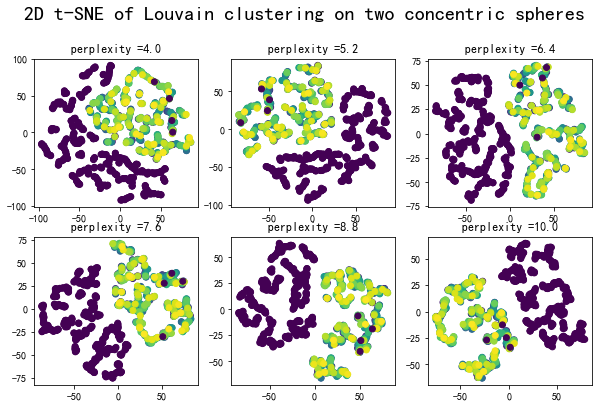

In [216]:
step = 6 
perplexitys = np.linspace(4, 10, step)

fig, axes = plt.subplots(2, step//2, figsize=(10, 6))

for ax, perp in zip(axes.flatten(), perplexitys):
    embed = TSNE(n_components = 2, perplexity = perp).fit_transform(X)
    ax.scatter(embed[:,0],embed[:,1], c = labels)
    ax.set_title(f"perplexity ={np.round(perp,3)}")

plt.suptitle("2D t-SNE of Louvain clustering on two concentric spheres", size=20, y=1)


Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.47 seconds.
Calculated PHATE in 1.45 seconds.
Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.20 seconds

Text(0.5, 1, 'PHATE of Louvain clustering on two concentric spheres')

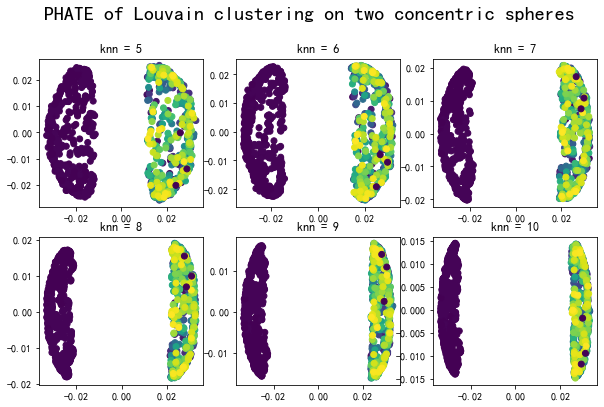

In [227]:
step = 6 
knns = np.linspace(5, 10, step, dtype=int)

fig, axes = plt.subplots(2, step//2, figsize=(10, 6))

for ax, knn in zip(axes.flatten(), knns):
    embed = PHATE(n_components = 2, knn=knn).fit_transform(X)
    ax.scatter(embed[:,0],embed[:,1], c = labels)
    ax.set_title(f'knn = {knn}') 

plt.suptitle("PHATE of Louvain clustering on two concentric spheres", size=20, y=1)


## Discussion

- How does Louvain compare to output of 2 previous clustering methods we tried? (spectral clustering and k-means clustering)

Answer: The output of Louvain clustering is similar to spectral clustering, both of them can distinguish 8 different clusters with appropriate combination of hyperparameters (sigma, pij, and resolution) while k-means clustering can't.

- what is goal of Louvain?

Answer: The goal of Louvain is to maximize modularity by merging communities in a large graph into smaller communities to make a smaller graph.

- how does Louvain perform on SBM at various $p_{ij}$ and $p_{ii}$?

Answer: when pij is small and pii is large, Louvain performs better on SBM.

- what effects did you observe when varying params of t-SNE?


- why these changes occurred?


- did you find an optimal set of params for visualization?


- or did this depend on specific clusters?

Answer: 

- The spread and the shape of clusters change when I change perplexity of t-SNE

- Because perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Changing perplexity will lead to change of cost function, resulting in the change of pairwise distances between similar data points and between dissimilar data points.

- I think it depends on specific clusters, because for the 3 datasets SBM, GMM and concentric spheres with different hyperparameters, the optimal perplexity is different.

- what effects did you observe when varying params of PHATE?


- why these changes occurred?


- did you find an optimal set of params for visualization?


- or did this depend on specific clusters? 

Answer:

- The size of cluster changes when I change `knn` and `t` of PHATE.


- Because `knn` is the number of nearest neighbors on which to build kernel. `t` is the time step of random walk, the power to which the diffusion operator is powered. This sets the level of diffusion. 


- I think the optimal set of params for visualization depends on specific clusters, because for the 3 datasets SBM, GMM and concentric spheres with different hyperparameters, the optimal perplexity is different.

- what differences between t-SNE and PHATE?


- why?

Answer:

- PHATE is more robust to capture both global and local structure of data while t-SNE only focuses on local structure of data at the cost of shattering the global picture. This is particularly significant when we compare visualization results on concentric spheres dataset. t-SNE can't distinguish 2 spheres clearly while PHATE creates a clear boundary between 2 spheres with different colors (purple vs. yellow).

- Because t-SNE is aimed to minimize Kullback–Leibler divergence, which push near points further near and faraway points further faraway, while PHATE use kernel to preserve local structure and use affinity to preserve global structure by “diffuse” through the data via a Markov random-walk.

- why is Gaussian mixture model a good data set to use to test clustering algo?

Answer: Because we know the probability for which each point belongs to a cluster in GMM. If the probability calculated by a clustering algo is similar as ground truth, then it is a decent algo.

- what modifications to GMM would you make to further test clustering algo?

Answer: I may filter the clusters with low probabilities and only keep clusters with high probabilities (e.g., 90%) after applying Gaussian kernel.

- what are other synthetic datasets you would use to test clustering algo?

Answer: A chain of interconnected rings which are orthogonal to each other.

# retinal bipolar dataset

- in final part, we don't use synthetic dataset, but use real world dataset

    single-cell RNA sequencing
    

- retinal bipolar dataset 视网膜双极细胞 数据集

    include markers of 21k bipolar cells of mouse retina
    

- retinal bipolar cells are neurons, 

    receive input from rod and cone photoreceptors of retina 视网膜的棒状和锥形光感受器, process it and pass it onward to brain
    
    class of retinal bipolar cells: categorized by their location (whether receive input from rods or cones), their function (whether their activation increases or decreases with increasing light), their molecular properties,
    
- but these distinctions don't always agree with other, i.e. can't define a unique class
    
    so unsupervised learning is a good solution

- Shekhar used a variant of Louvain combined with prior know of known clusters

    identified 15 different classes of retinal bipolar cells
    

- you will apply your clustering skills to verify this classification

## 12 steps:

1. load Retinal Bipolar dataset from `retinal-bipolar-data.pickle` in `data` folder

    and its metadata from `retinal-bipolar-metadata.pickle`
    
    import `pandas`,
    
    use `pandas.read_pickle("file_path")` to read dataset
    
    Note: metadata has 26 cluster labels though Shekhar only found 15 of them biologically significant

In [49]:
with open('data/retinal-bipolar-data.pickle', 'rb') as f:
    data = pd.read_pickle(f)

with open('data/retinal-bipolar-metadata.pickle', 'rb') as f:
    metadata = pd.read_pickle(f)

2. unaltered dataset has > 15k columns corresponding to 15k markers for each of 21k cells

    to make computation feasible, apply PCA to columns of dataset choose 1st 100 PCA components
    
    import `scprep` library
    
    use `scprep.reduce.pca` to perform PCA

In [50]:
data = scprep.reduce.pca(data, n_components=100, method='dense')

3. sample 3k cells from 21k cells 

    use `scprep.select.subsample` to randomly select 3k cells and their corresponding markers from dataset and its metadata

In [51]:
data, metadata = scprep.select.subsample(data, metadata, n=3000)


4. build a graph from new data using an adaptive Gaussian kernel with k=10

In [52]:
A = gaussian_kernel(data.values, k=10) 

fixed bandwidth specified


5. cluster data using k-means, spectral clustering, Louvain

In [19]:
# k-means
k_means = KMeans(n_clusters=26).fit(data.values).labels_ 

In [ ]:
# spectral clustering
Laplacian = L(A) 
spectral = SC(Laplacian,26,sklearn=True) 

In [28]:
# Louvain
G = nx.from_numpy_array(A) 
louvain = np.array(list((community_louvain.best_partition(G)).values()))

6. visualize new data using PHATE, colored by each of above clusterings

    produce similar visualizations using t-SNE
    
    what differences do you notice?

In [ ]:
# calculate PHATE embeddings of data 
phate = PHATE().fit_transform(data.values)

# calculate t-SNE embeddings of data 
tsne = TSNE().fit_transform(data.values)

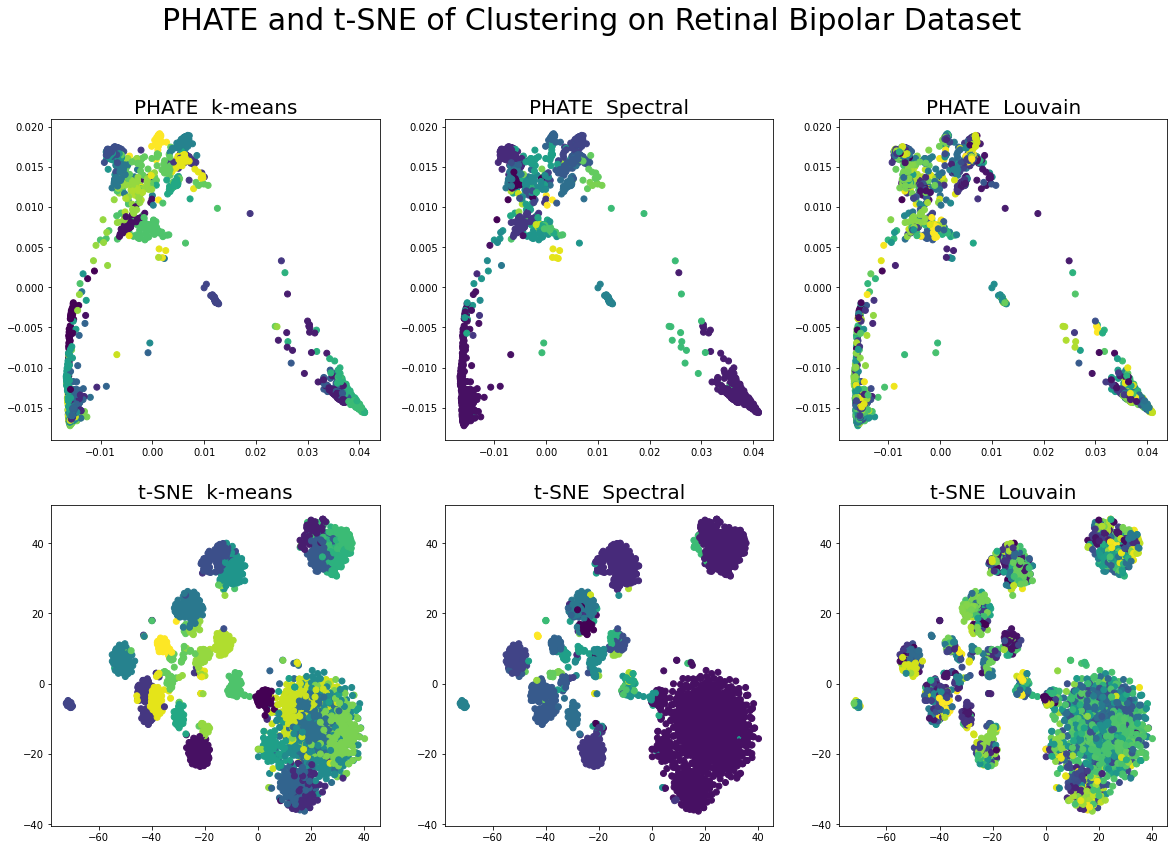

In [48]:
embeddings = [phate, tsne]
labels = [k_means, spectral, louvain]
dimred_methods = ['PHATE', 't-SNE']
cluster_methods = ["k-means", "Spectral", "Louvain"]

fig, axes = plt.subplots(2, 3, figsize=(20, 13))
 
plt.suptitle("PHATE and t-SNE of Clustering on Retinal Bipolar Dataset", 
             size=30, y=1)

for i in range(2):
    for j in range(3):
        axes[i][j].scatter(embeddings[i][:,0], embeddings[i][:,1],c=labels[j])
        axes[i][j].set_title(f"{dimred_methods[i]}  {cluster_methods[j]}", size=20)   

7. change kernel param k to obtain different cluster assignments

    also, change Louvain params
    
    visualize each of new clusterings with a recolored PHATE plot

In [50]:
ks = [5, 10, 15, 20, 25]

spectrals = [0 for i in range(5)]

louvains = [0 for i in range(5)]

for i in range(5):
    
    A = gaussian_kernel(data.values, k=ks[i]) 
    
    spectrals[i] = SC(L(A), 26, sklearn=True)

    louvains[i] = np.array(list((community_louvain.best_partition(nx.from_numpy_array(A))).values()))

fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


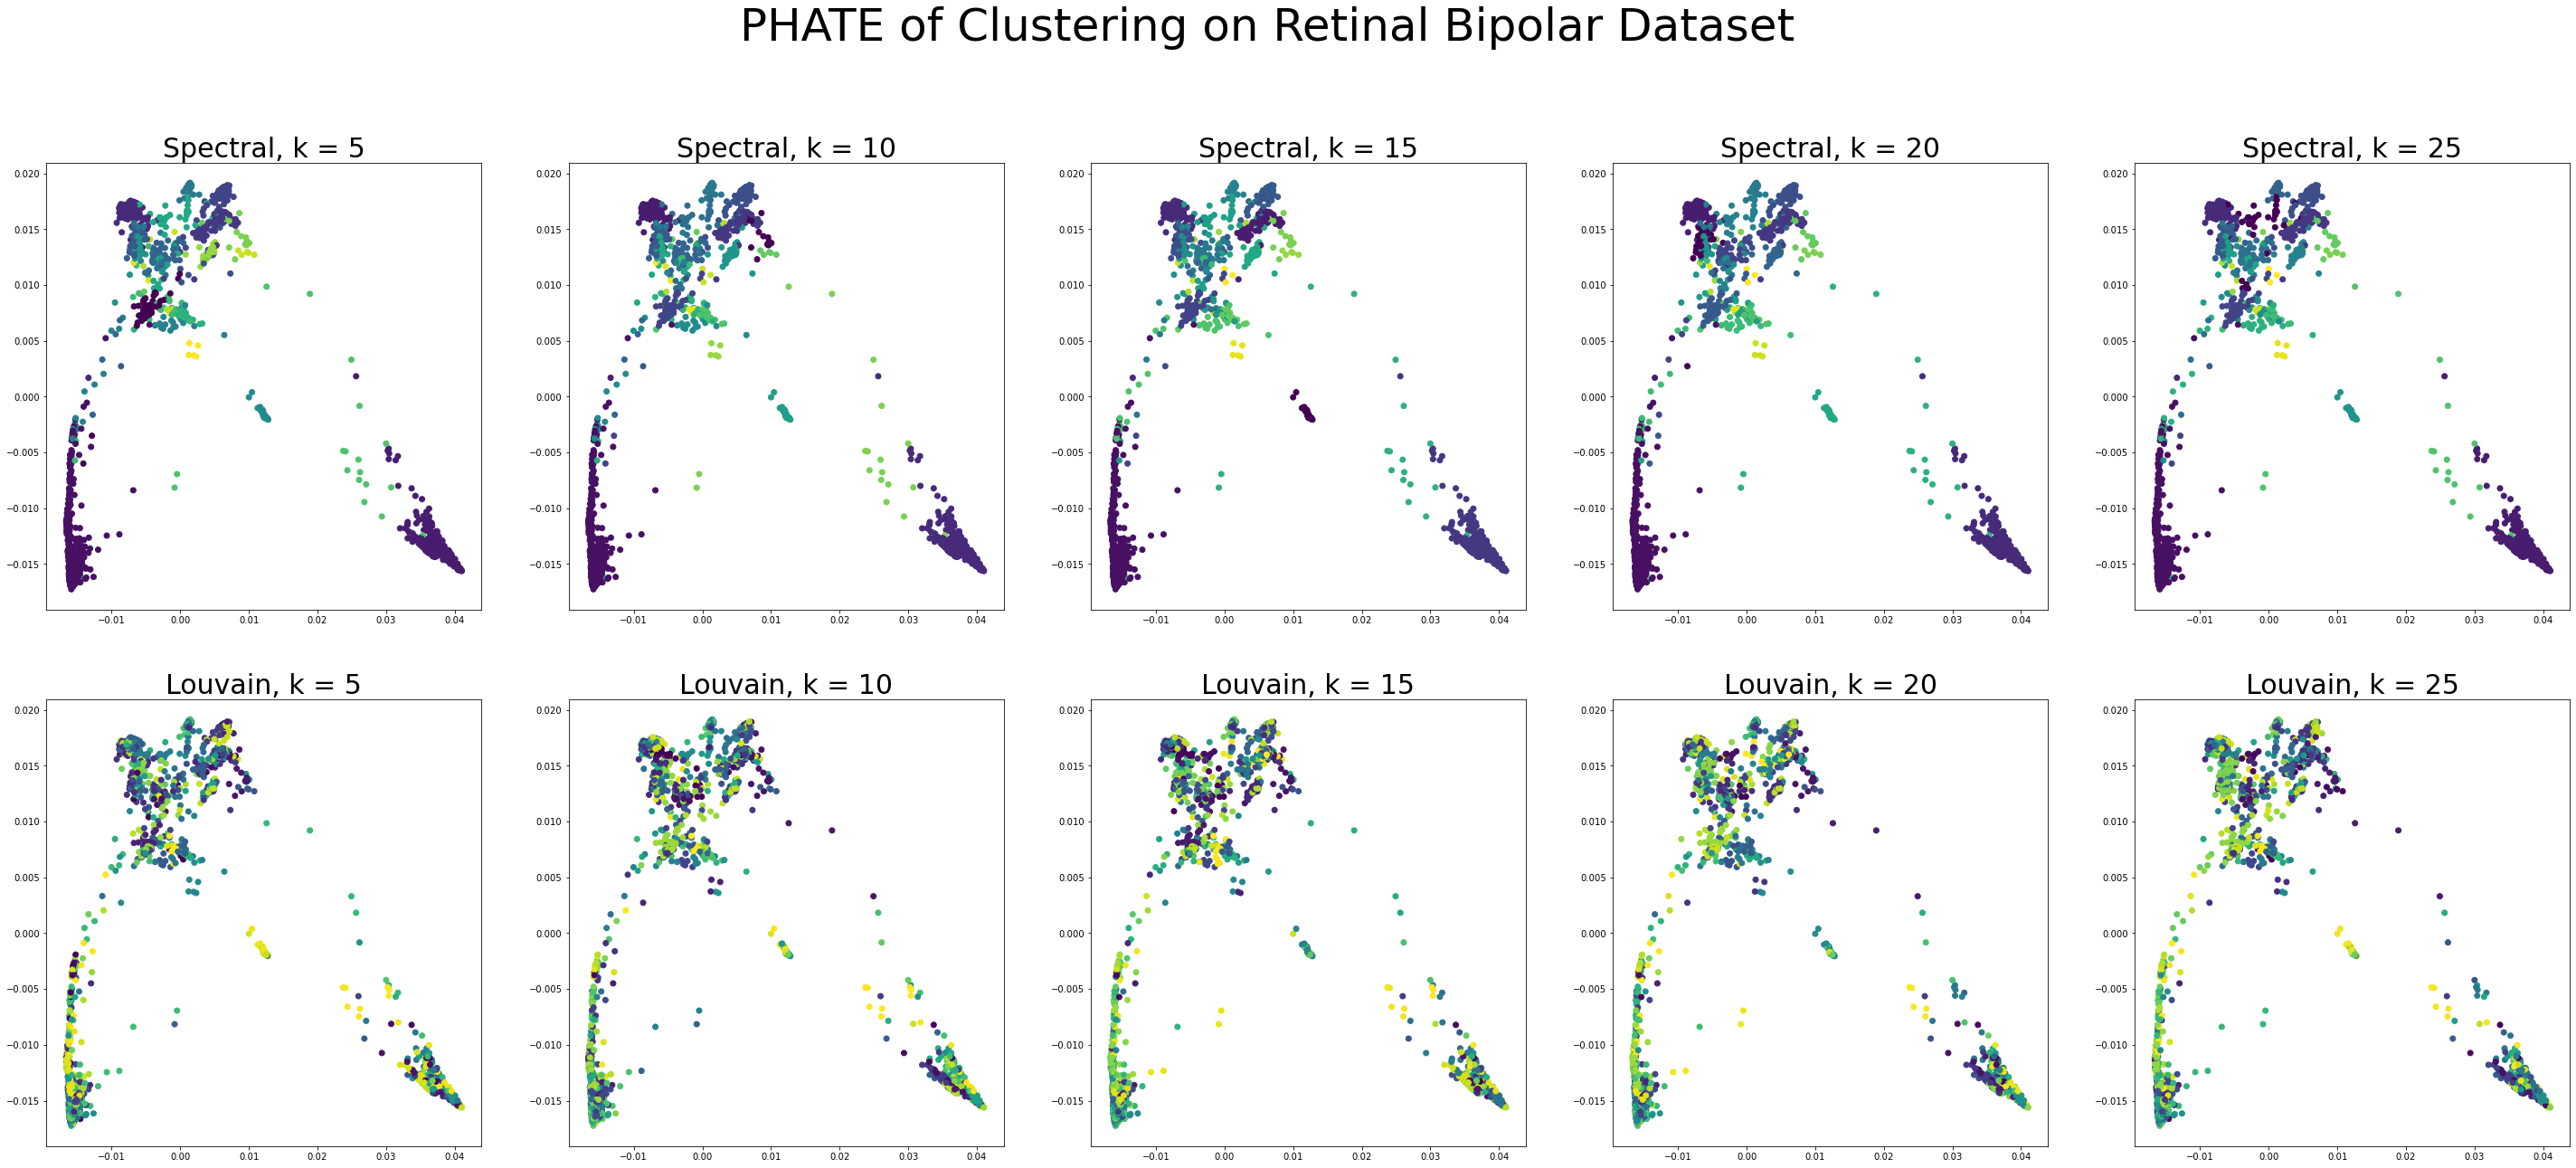

In [52]:
labels = [spectrals, louvains]
cluster_methods = ["Spectral", "Louvain"]

fig, axes = plt.subplots(2, 5, figsize=(50, 20))
 
plt.suptitle("PHATE of Clustering on Retinal Bipolar Dataset", 
             size=50, y=1)

for i in range(2):
    for j in range(5):
        axes[i][j].scatter(phate[:,0], phate[:,1], c=labels[i][j])
        axes[i][j].set_title(f"{cluster_methods[i]}, k = {ks[j]}", size=30) 

In [64]:
ks = [5, 10, 15, 20, 25]

resolutions = [1, 3, 5, 7, 9]

louvains = [[0 for i in range(5)] for j in range(5)]

for i in range(5):
    A = gaussian_kernel(data.values, k=ks[i])
    for j in range(5):
        louvains[i][j] = np.array(list((community_louvain.best_partition(nx.from_numpy_array(A), resolution=resolutions[j])).values()))

fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified
fixed bandwidth specified


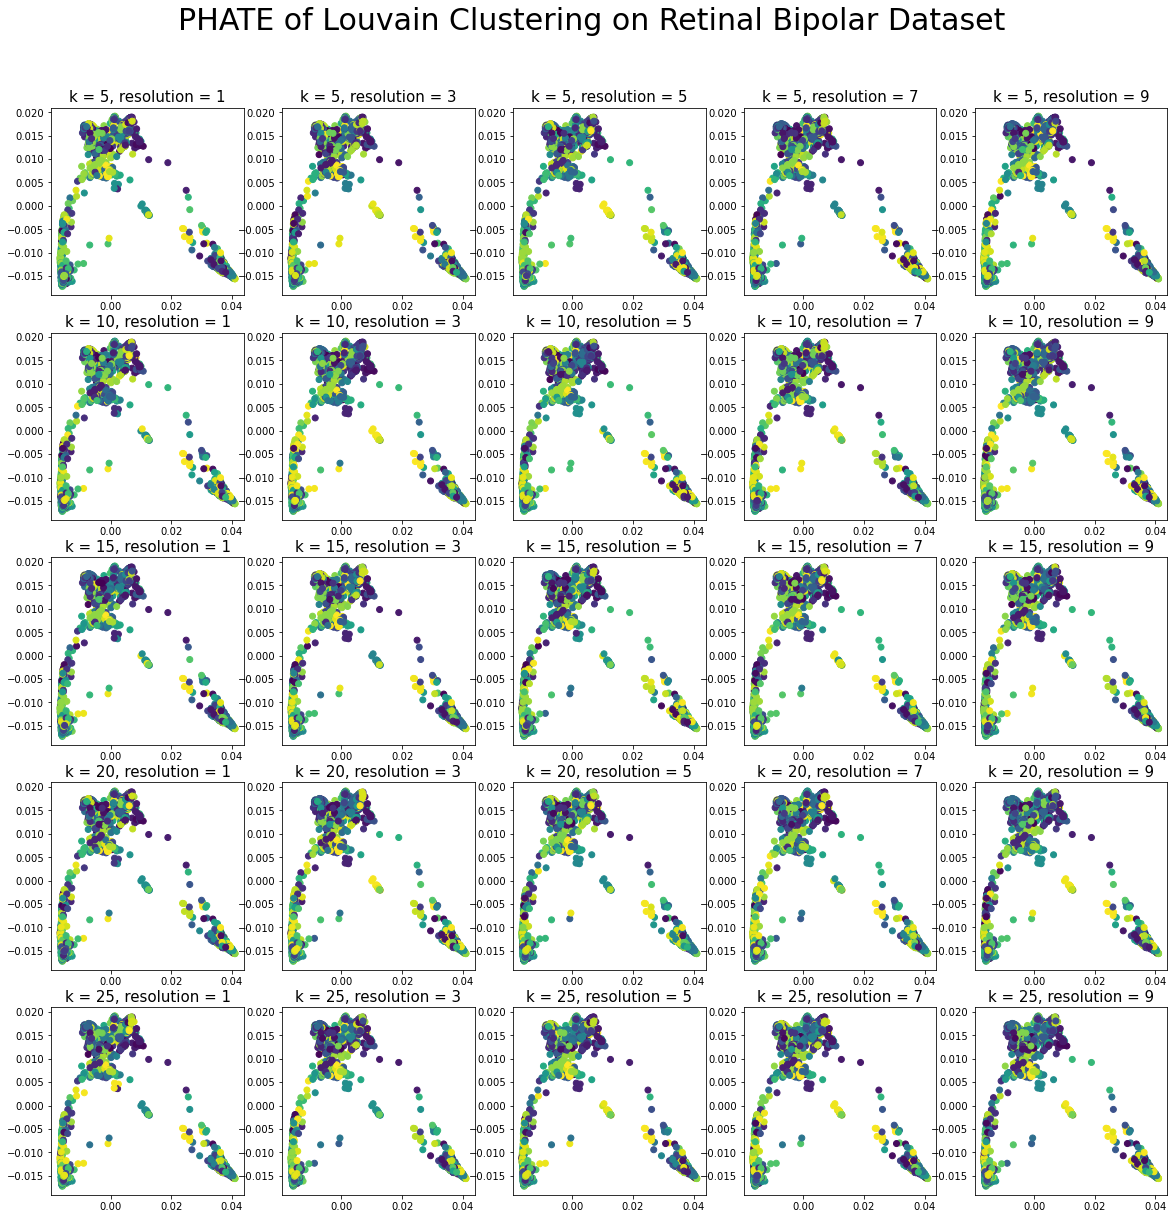

In [69]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
 
plt.suptitle("PHATE of Louvain Clustering on Retinal Bipolar Dataset", 
             size=30, y=0.95)

for i in range(5):
    for j in range(5):
        axes[i][j].scatter(phate[:,0], phate[:,1], c=louvains[i][j])
        axes[i][j].set_title(f"k = {ks[i]}, resolution = {resolutions[j]}", size=15) 

8. plot 2nd and 3rd eigenvectors of Graph Laplacian

    colored by cluster assignments

In [55]:
A = gaussian_kernel(data.values, k=10) # affinity matrix
Laplacian = L(A) # graph laplacian
e, psi = compute_fourier_basis(Laplacian) # eigenvalues and eigenvectors of graph laplacian

fixed bandwidth specified


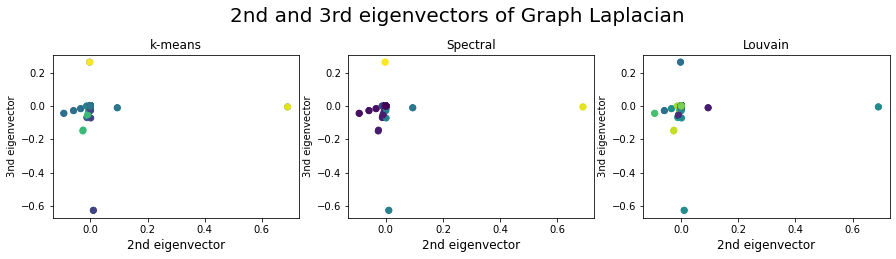

In [62]:
labels = [k_means, spectral, louvain]

cluster_methods = ["k-means", "Spectral", "Louvain"]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
 
plt.suptitle("2nd and 3rd eigenvectors of Graph Laplacian", 
             size=20, y=1.1)
  
for i in range(3):
    
    axes[i].scatter(psi[:,1] ,psi[:,2],c = labels[i]) 
    axes[i].set_title(cluster_methods[i])  
    axes[i].set_xlabel("2nd eigenvector", fontsize=12)
    axes[i].set_ylabel("3nd eigenvector", fontsize=10)

9. color PHATE plot using different channels in data

    e.g., different columns of metadata matrix
    
    can you find any channels that seem to correspond to your cluster assignments?

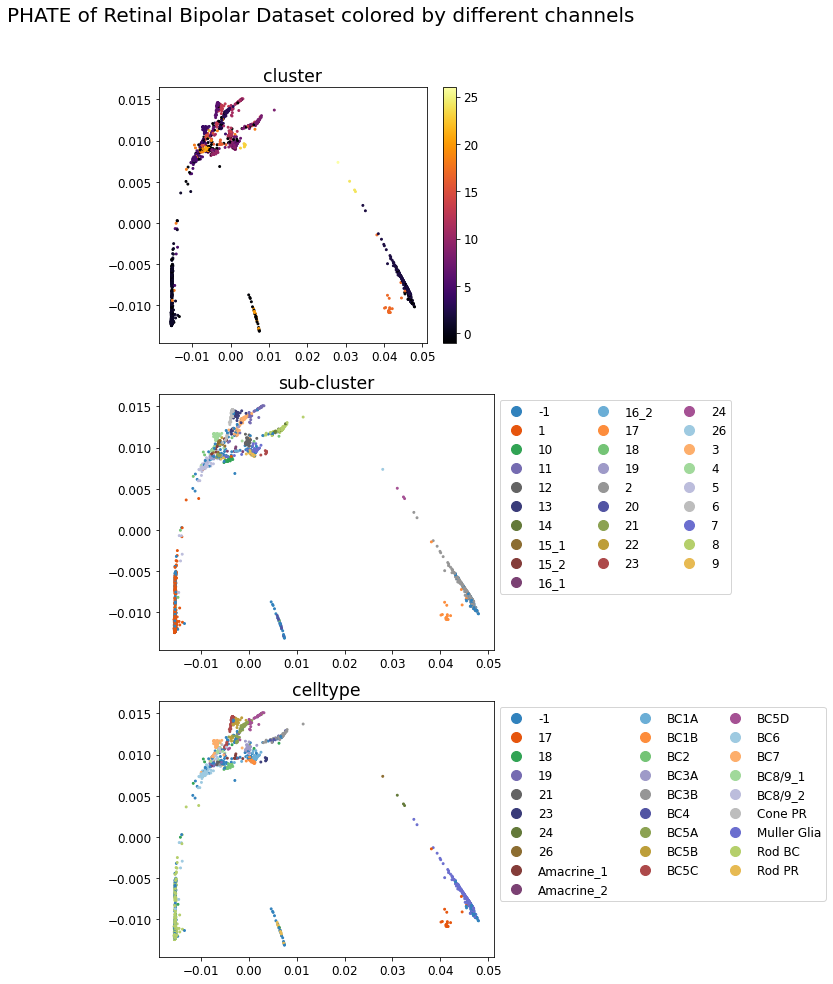

In [189]:
metadata_channels = ['CLUSTER', 'SUB-CLUSTER', 'CELLTYPE']

fig, axes = plt.subplots(3, 1, figsize=(6, 16))

plt.suptitle("PHATE of Retinal Bipolar Dataset colored by different channels", 
             size=20, y=0.95)

for i in range(3): 
    scprep.plot.scatter2d(phate, c = metadata[metadata_channels[i]], 
                          title=f'{metadata_channels[i]}'.lower(),
                          legend_anchor=(1,1),ax=axes[i])  
    

Answer: channel Rod BC, Muller Glia, BC5A, BC5C, BC5B, BC6, BC1A, BC2, BC3A

10. apply an ideal low-pass filter to some of channels you found above,

    treat gene expression as a signal over graph
    
    rerun visualizations using these new, filtered channels to color PHATE plot
    
    how much has changed?
    
    do any denoised channels better represent true clustering?

In [53]:
channels = ['Rod BC', 'Muller Glia', 'BC5A', 'BC5C', 'BC5B', 'BC6', 'BC1A', 'BC2', 'BC3A']
 
filtered_id = ~(np.in1d(metadata['CELLTYPE'].values, channels))

# affinity matrix of data only with channels to be filtered
A = gaussian_kernel((data.values)[filtered_id], k=10) # affinity matrix
Laplacian = L(A) # graph laplacian
e, psi = compute_fourier_basis(Laplacian) # eigenvalues and eigenvectors of graph laplacian
H = filterbank_matrix(psi, e, 'low pass') 

fixed bandwidth specified


In [54]:
filtered_data = np.copy(data.values)

filtered_data[filtered_id] = H @ filtered_data[filtered_id]

# calculate PHATE embeddings of filtered data 
filtered_phate = PHATE().fit_transform(filtered_data)

Calculating PHATE...
  Running PHATE on 3000 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.63 seconds.
    Calculating affinities...
    Calculated affinities in 0.15 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.27 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.43 seconds.
  Calculated landmark operator in 8.25 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 3.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.73 seconds.
Calculated PHATE in 18.55 seconds.


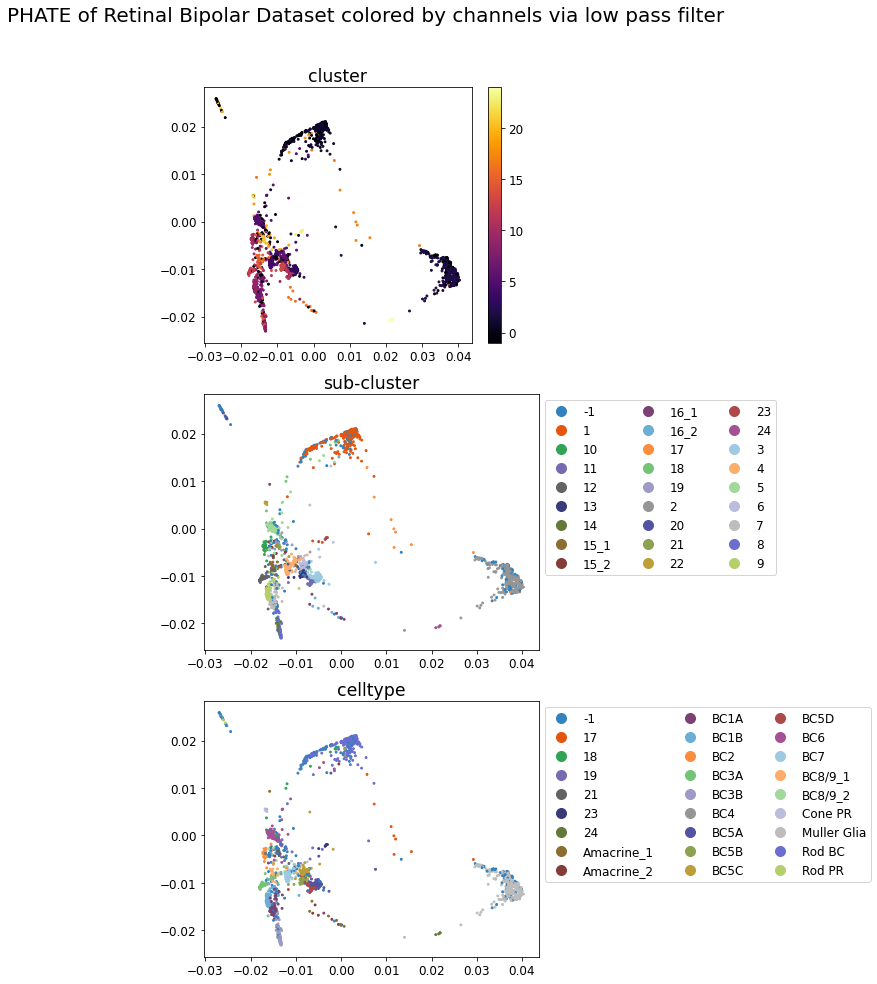

In [55]:
metadata_channels = ['CLUSTER', 'SUB-CLUSTER', 'CELLTYPE']

fig, axes = plt.subplots(3, 1, figsize=(6, 16))

plt.suptitle("PHATE of Retinal Bipolar Dataset colored by channels via low pass filter", 
             size=20, y=0.95)

for i in range(3): 
    scprep.plot.scatter2d(filtered_phate, c = metadata[metadata_channels[i]], 
                          title=f'{metadata_channels[i]}'.lower(),
                          legend_anchor=(1,1),ax=axes[i])  
    

11. binarize 二值化 the kernel such that it's no longer a weighted graph

    i.e., if a value > some threshold, it's 1, otherwise 0
    
    rerun Louvain with binarized kernel

In [152]:
np.amin(A), np.amax(A) 

(0.0, 3.2182218100392775e-15)

In [153]:
A = gaussian_kernel(data.values) # affinity matrix of data
binarized_A = np.where(A > np.amax(A)/2, 1, 0)
G = nx.from_numpy_array(binarized_A)
partition = community_louvain.best_partition(G)
binarized_louvain = np.asarray(list(partition.values()))

# calculate PHATE embeddings of data 
phate = PHATE().fit_transform(data.values)

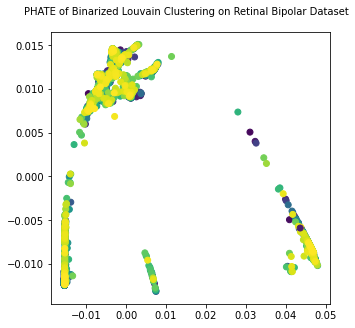

In [157]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

plt.suptitle("PHATE of Binarized Louvain Clustering on Retinal Bipolar Dataset",
             size=10, y=0.95)

axes.scatter(phate[:, 0], phate[:, 1], c=binarized_louvain)


12. compare your clusters to Shekhar's by coloring your PHATE plots with cluster number provided in metadata

    describe any relationships you notice between those clusters and the clusters you've obtained with k-means, Louvain, spectral clustering

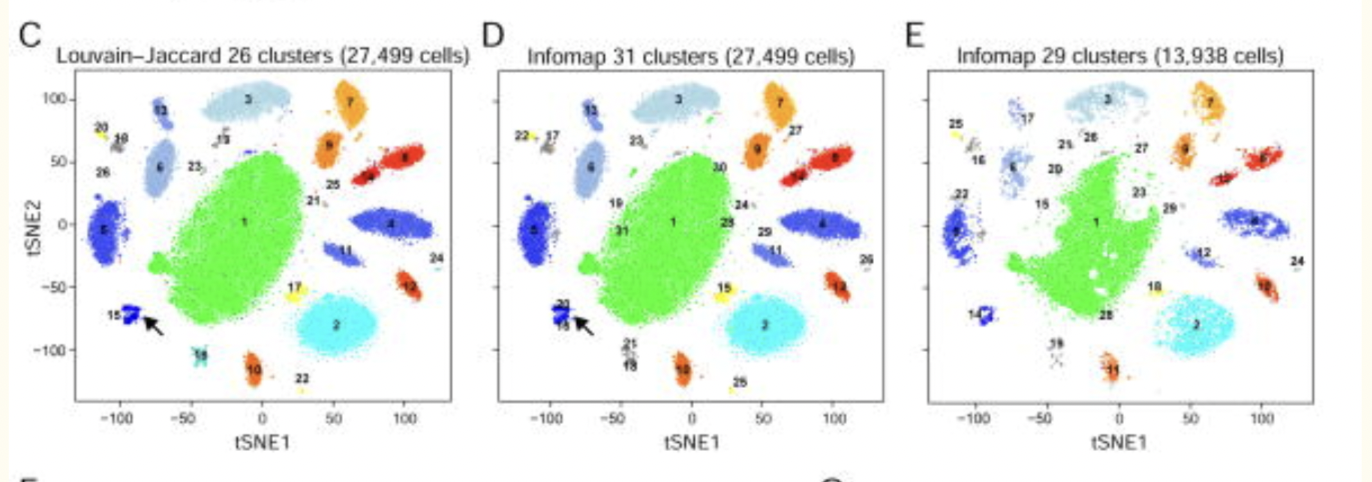

## q 8.1

- How many clusters did Louvain produce?


- How many clusters did PHATE and t-SNE suggest?


- to what extent did different clustering methods params affect this number?

Answer: 

- I can't see clearly how many clusters Louvain produced.

- t-SNE suggests 18 clusters. I can't see clearly how many clusters PHATE suggests.

- The different parameters don't affect too much on the number of clusters.

## q 8.2

- in a biological setting, how would you interpret different clusters?


- more specifically, how would you interpret any variation you noticed from 15 clusters described by Shekhar?


Answer:

- Different clusters are gene variation in single cell level

## q 8.3

- what did you notive when you plotted eigenvetors of Graph Laplacian?

Answer: They are orthogonal to each other

## q 8.4

- what's effect of low-pass filtering a feature on the graph?


- in what context could this be useful for data analysis?

Answer: The low-pass filter decay the low frequency signals which are often noises on the graph while magnify the high frequency signals on the graph which tend to be real signals. When noise is low-frequency signal or we want to smooth the signals. 

## q 8.5

- how does binarization of kernel affact your clustering?


- why?

Answer: binarization of kernel reduces the number of clusters because it forces the entries in the affinity matrix to be either 0 or 1 to simplify the connectivity between clusters.